In [ ]:
import os

In [ ]:
pip install ges

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 1.9 MB/s eta 0:00:00


In [ ]:
import ges as GES

In [1]:
!pip install scikit-learn pyro-ppl causalml econml pgmpy dowhy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 398.4/398.4 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.1/192.1 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/3

In [2]:
#Load the librarys
import numpy as np
import pandas as pd
import seaborn as sns #Graph library that use matplot in background
import matplotlib.pyplot as plt #to plot some parameters in seaborn
from sklearn.model_selection import train_test_split
#from causalml.inference.tree import CausalForest
from dowhy import CausalModel
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from econml.dml import CausalForestDML
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist
import pyro
import torch

In [3]:
pip install ges

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 2.2 MB/s eta 0:00:00


In [4]:
import ges as GES

In [5]:
from dowhy import gcm

In [6]:
import networkx as nx

In [7]:
# Important Libraries

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

# Step 1: Data Engineering


In [32]:
# @title Importing the Data
# The raw link to the CSV file in the GitHub repository
url = 'https://raw.githubusercontent.com/dzrich/PhD_Research_in_CausalML/main/Data/CreditRiskDataset.csv'

# Load the CSV file into a pandas DataFrame
CreditRiskDataset = pd.read_csv(url)

# Display the first few rows of the dataset
print(CreditRiskDataset.head())

   person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D      35000          16.02            1   
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL          C      35000          15.23            1   
4     MEDICAL          C      35000          14.27            1   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  \
0                 0.59                         Y                           3  

## First Look at the data:
Looking the Type of Data
Null Numbers
Unique values
The first rows of our dataset


In [33]:
#Searching for Missings,type of data and also know the shape of data
print(CreditRiskDataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
 12  OTHER_DEBT                  32581 non-null  float64
 13  TIME_WITH_BANK              325

#### Drop unwanted Columns

In [34]:
df = CreditRiskDataset.drop(['Unnamed: 15','Unnamed: 16'], axis=1)

#### Impute missing values

In [35]:
df['person_emp_length'] = df['person_emp_length'].fillna(df['person_emp_length'].mean())
df['loan_int_rate'] = df['loan_int_rate'].fillna(df['loan_int_rate'].mean())

In [36]:
df["person_emp_length"].fillna((df["person_emp_length"].median()), inplace = True)
df["loan_int_rate"].fillna((df["loan_int_rate"].mean()), inplace = True)
#check
df["loan_int_rate"].isnull().sum()

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




0

In [37]:
import pandas as pd

# Assuming 'df' is your DataFrame

# Specify the numerical columns you want to categorize
numerical_cols = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
                  'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
                  'OTHER_DEBT', 'LOAN_PERIOD in days','TIME_WITH_BANK']  # Add more if needed

# Group numerical variables into 20 categories
for col in numerical_cols:
    df[col + '_cat'] = pd.cut(df[col], bins=10, labels=False)

In [38]:
df = df.drop(columns=numerical_cols)

In [22]:
df.head(20)

,person_home_ownership,loan_intent,loan_grade,loan_status,cb_person_default_on_file,person_age_cat,person_income_cat,person_emp_length_cat,loan_amnt_cat,loan_int_rate_cat,loan_percent_income_cat,cb_person_cred_hist_length_cat,OTHER_DEBT_cat,LOAN_PERIOD in days_cat,TIME_WITH_BANK_cat
0,RENT,PERSONAL,D,1,Y,0,0,9,9,5,7,0,3,3,7
1,OWN,EDUCATION,B,0,N,0,0,0,0,3,1,0,3,3,6
2,MORTGAGE,MEDICAL,C,1,N,0,0,0,1,4,6,0,2,2,9
3,RENT,MEDICAL,C,1,N,0,0,0,9,5,6,0,0,2,4
4,RENT,MEDICAL,C,1,Y,0,0,0,9,4,6,0,5,5,8
5,OWN,VENTURE,A,1,N,0,0,0,0,0,3,0,3,3,2
6,RENT,EDUCATION,B,1,N,0,0,0,9,3,5,0,7,7,6
7,RENT,MEDICAL,B,1,N,0,0,0,9,3,5,0,0,7,3
8,RENT,PERSONAL,A,1,N,0,0,0,9,1,5,0,9,9,3
9,OWN,VENTURE,D,1,N,0,0,0,0,5,1,0,1,1,0


In [42]:
import pandas as pd
import numpy as np

def calculate_woe(df, independent_vars, target):
    """
    Calculate Weight of Evidence (WOE) for independent variables.

    Parameters:
    df (DataFrame): The input DataFrame containing independent variables and the target variable.
    independent_vars (list): List of independent variables to transform.
    target (str): Name of the target variable (binary: 0=Good, 1=Bad).

    Returns:
    df_transformed (DataFrame): DataFrame with original values replaced by WOE values.
    woe_dict (dict): Dictionary containing WOE values for each bin of each variable.
    """
    df_transformed = df.copy()
    woe_dict = {}

    for feature in df.columns:
        # Create WOE table
        woe_table = df.groupby(feature)[target].agg(['count', 'sum'])
        woe_table.columns = ['Total', 'Bad']
        woe_table['Good'] = woe_table['Total'] - woe_table['Bad']

        # Avoid division by zero using small values
        woe_table['%Bad'] = (woe_table['Bad'] / woe_table['Bad'].sum()).replace(0, 0.0001)
        woe_table['%Good'] = (woe_table['Good'] / woe_table['Good'].sum()).replace(0, 0.0001)

        # Compute WOE
        woe_table['WOE'] = np.log(woe_table['%Good'] / woe_table['%Bad'])

        # Store WOE values
        woe_dict[feature] = woe_table['WOE'].to_dict()

        # Replace original values with WOE
        df_transformed[feature] = df_transformed[feature].map(woe_dict[feature])

    return df_transformed, woe_dict

target_variable = 'loan_status'

# Calculate WOE for all features (excluding the target)
for feature in df.columns:
    if feature != target_variable:
          df_transformed, woe_values = calculate_woe(df, feature, target_variable)

    print("WOE Transformed DataFrame:")
    print(df_transformed)
    print("\nWOE Values:")
    print(woe_values)



WOE Transformed DataFrame:
       person_home_ownership  loan_intent  loan_grade  loan_status  \
0                  -0.502794     0.116930   -1.642256     -9.21034   
1                   1.240379     0.293941    0.361439      9.21034   
2                   0.663067    -0.266537    0.064638     -9.21034   
3                  -0.502794    -0.266537    0.064638     -9.21034   
4                  -0.502794    -0.266537    0.064638     -9.21034   
...                      ...          ...         ...          ...   
32576               0.663067     0.116930    0.064638      9.21034   
32577               0.663067     0.116930    0.925682      9.21034   
32578              -0.502794    -0.235757    0.361439     -9.21034   
32579               0.663067     0.116930    0.361439      9.21034   
32580              -0.502794    -0.266537    0.361439      9.21034   

       cb_person_default_on_file  person_age_cat  person_income_cat  \
0                      -0.778641       -0.014277          -0.

In [53]:
# Assuming 'df_transformed' is your DataFrame

df_transformed['loan_status'] = df_transformed['loan_status'].replace({
    -9.210340371976182: 1,
    9.210340371976184: 0
})

In [54]:
# Assuming 'df' is your DataFrame and 'loan_status_1' is the column you want to group by

# Assuming 'df_transformed' is your DataFrame

unique_values = df_transformed['loan_status'].unique()
print("Unique values in 'loan_status':", unique_values)

for value in unique_values:
    count = df_transformed['loan_status'][df_transformed['loan_status'] == value].count()
    print(f"Count of '{value}': {count}")

Unique values in 'loan_status': [1. 0.]
Count of '1.0': 7108
Count of '0.0': 25473


In [55]:
df = df_transformed

In [56]:
df.head()

,person_home_ownership,loan_intent,loan_grade,loan_status,cb_person_default_on_file,person_age_cat,person_income_cat,person_emp_length_cat,loan_amnt_cat,loan_int_rate_cat,loan_percent_income_cat,cb_person_cred_hist_length_cat,OTHER_DEBT_cat,LOAN_PERIOD in days_cat,TIME_WITH_BANK_cat
0,-0.502794,0.116930,-1.642256,1.0,-0.778641,-0.014277,-0.000812,-1.276398,-0.604304,-1.277024,-2.465982,-0.052318,-0.027223,-0.035791,-0.002582
1,1.240379,0.293941,0.361439,0.0,0.213533,-0.014277,-0.000812,-0.019229,0.033100,0.199846,0.608780,-0.052318,-0.027223,-0.035791,0.032077
2,0.663067,-0.266537,0.064638,1.0,0.213533,-0.014277,-0.000812,-0.019229,0.276636,-0.095348,-2.476975,-0.052318,0.044680,0.024039,0.037379
3,-0.502794,-0.266537,0.064638,1.0,0.213533,-0.014277,-0.000812,-0.019229,-0.604304,-1.277024,-2.476975,-0.052318,-0.025156,0.024039,-0.031847
4,-0.502794,-0.266537,0.064638,1.0,-0.778641,-0.014277,-0.000812,-0.019229,-0.604304,-0.095348,-2.476975,-0.052318,0.023014,0.040510,0.034831


# Perfom Some explorations:
 - Starting by distribuition of column Age.
 - Some Seaborn graphical
 - Columns crossing

**Let's start looking through target variable and their distribuition

Text(0.5, 0, 'Default Status')

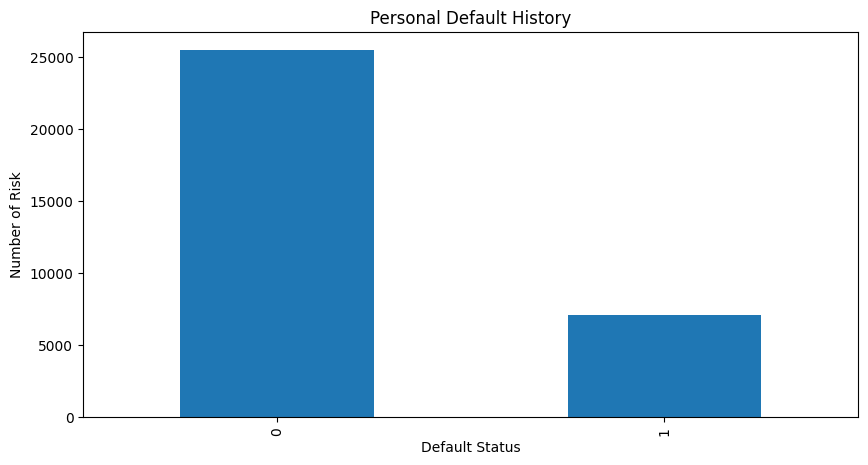

In [ ]:
df.loan_status.value_counts().plot(kind='bar', figsize =(10,5)) #loan_status cb_person_default_on_file
plt.title("Personal Default History")
plt.ylabel('Number of Risk')
plt.xlabel('Default Status')

In [ ]:
df_good = df.loc[df["loan_status"] == 0]['person_age'].values.tolist()  #loan_status cb_person_default_on_file
df_bad = df.loc[df["loan_status"] == 1]['person_age'].values.tolist()
df_age = df['person_age'].values.tolist()

Text(0.5, 0, 'Age')

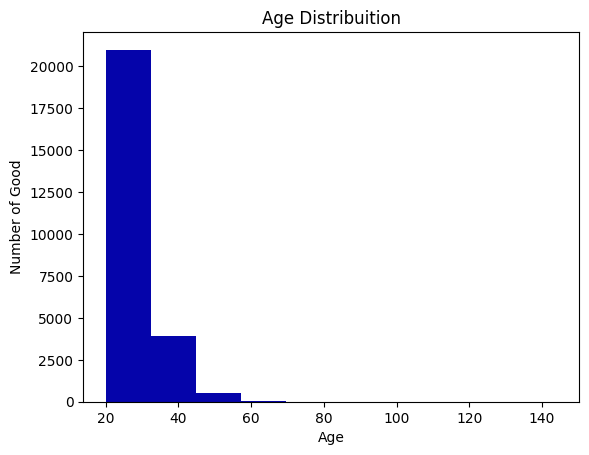

In [ ]:
trace0 = plt.hist( x= df_good,bins=None,range=None,density=False,weights=None,
    cumulative=False,bottom=None,histtype='bar',align='mid',orientation='vertical',
    rwidth=None,log=False,color='#0504aa',label='N',stacked=False)
plt.title("Age Distribuition")
plt.ylabel('Number of Good')
plt.xlabel('Age')

Text(0.5, 0, 'Age')

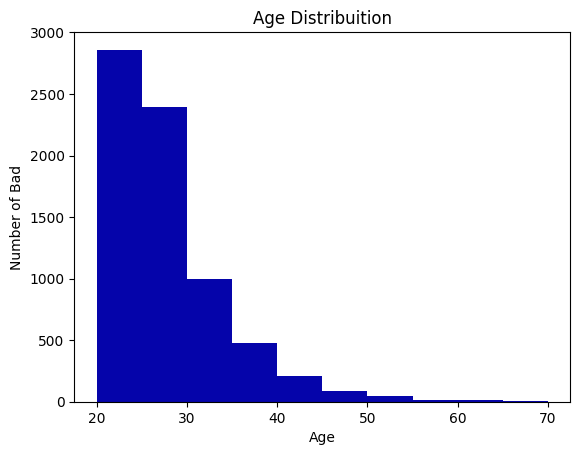

In [ ]:
trace1 = plt.hist(x=df_bad,bins=None,range=None,density=False,weights=None,
    cumulative=False,bottom=None,histtype='bar',align='mid',orientation='vertical',
    rwidth=None,log=False,color='#0504aa',label='Good',stacked=False)
plt.title("Age Distribuition")
plt.ylabel('Number of Bad')
plt.xlabel('Age')

Text(0.5, 0, 'Age')

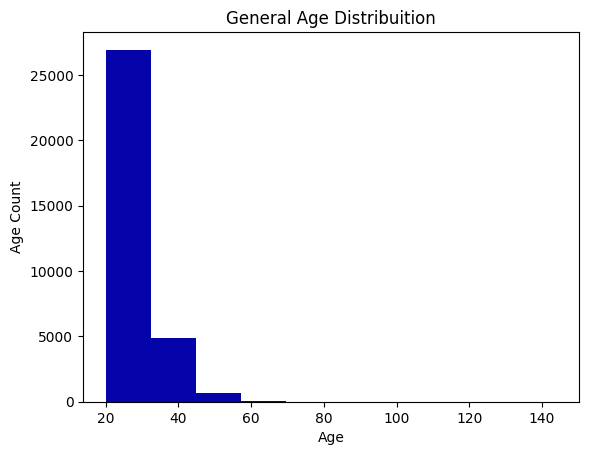

In [ ]:
trace2 = plt.hist(x=df_age,bins=None,range=None,density=False,weights=None,
    cumulative=False,bottom=None,histtype='bar',align='mid',orientation='vertical',
    rwidth=None,log=False,color='#0504aa',label='Good',stacked=False)
plt.title("General Age Distribuition")
plt.ylabel('Age Count')
plt.xlabel('Age')

In [ ]:
df_good = df[df["loan_status"] == 0]  #cb_person_default_on_file loan_status
df_bad = df[df["loan_status"] == 1]

## Encoding the Independent Variable
Use two classes: First, The column transform the classes from the compose module of Sklearn library. Second, the OHE class module for preprocessing from the Sklearn library

In [ ]:
df = pd.get_dummies(df, columns=['person_home_ownership'],dtype= float)
df = pd.get_dummies(df, columns=['loan_intent'],dtype= float)
df = pd.get_dummies(df, columns=['loan_grade'],dtype= float)
df = pd.get_dummies(df, columns=['cb_person_default_on_file'],dtype= float)
df = pd.get_dummies(df, columns=['loan_status'],dtype= float)

## **Correlational Machine Learning:**

**Looking at the correlation of the data**

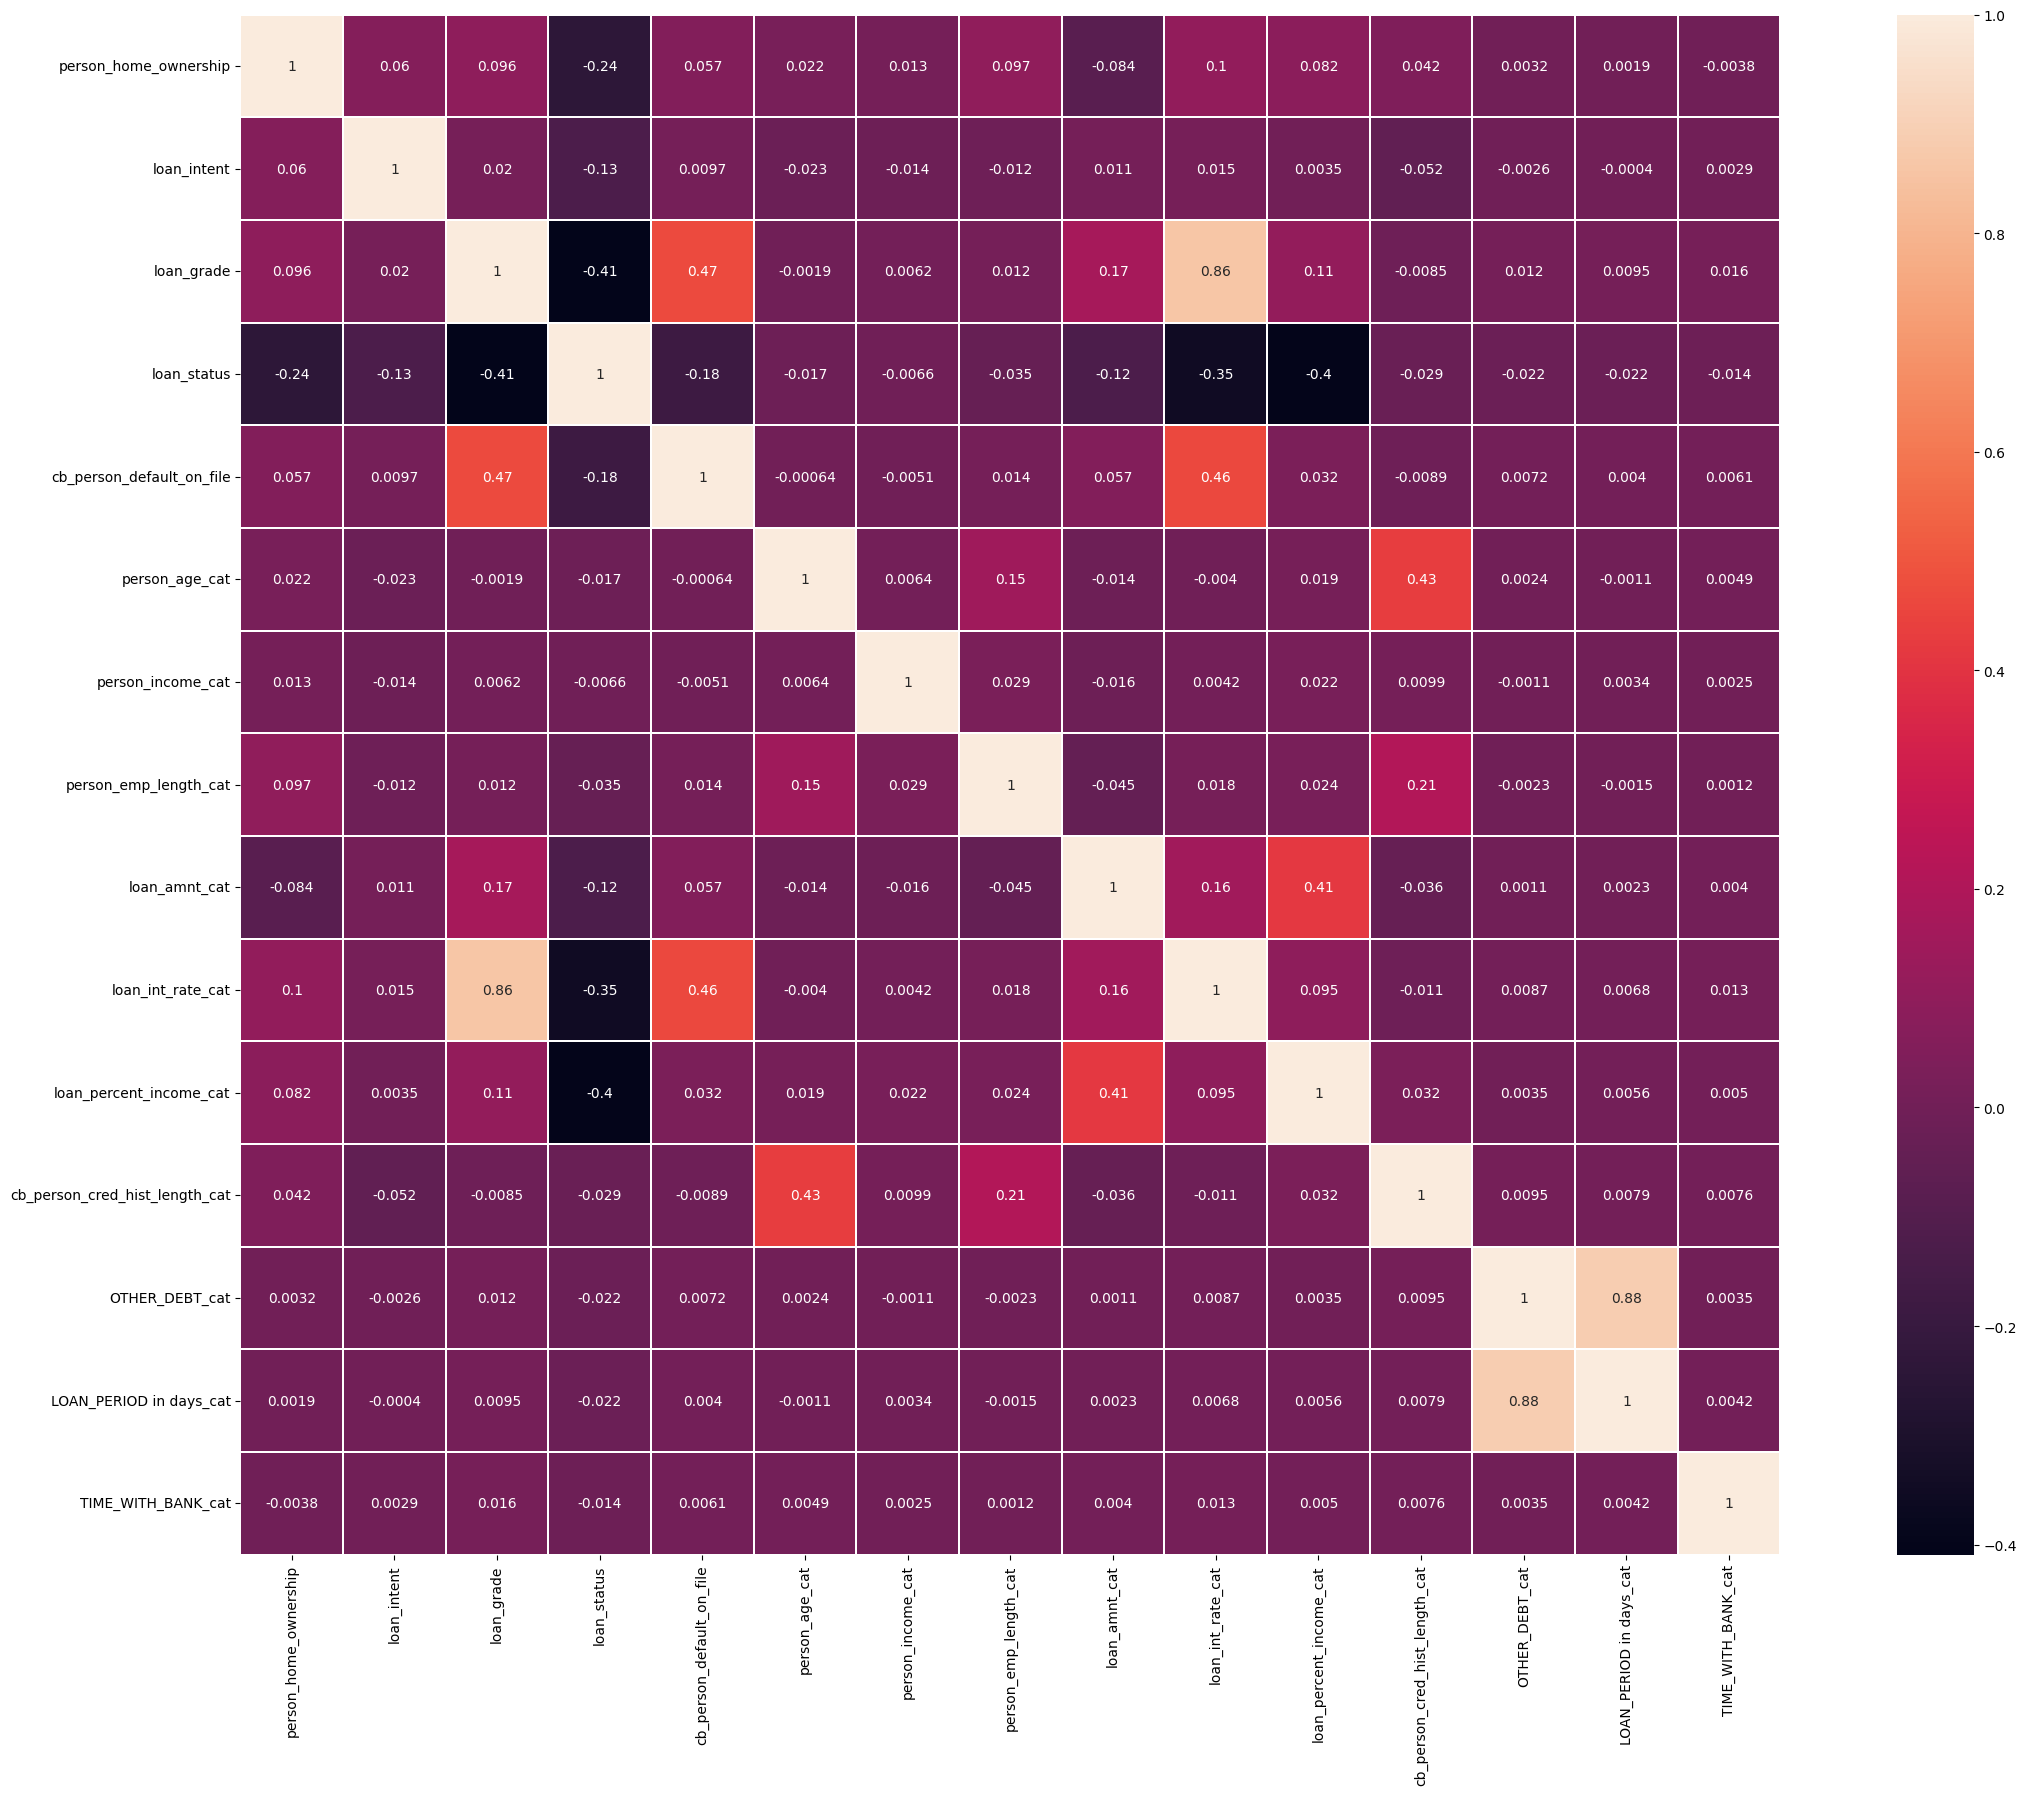

In [57]:
plt.figure(figsize=(30,20))
sns.heatmap(df.astype(float).corr(),linewidths=0.1,vmax=1.0,
            square=True,  linecolor='white', annot=True)
plt.show()

In [ ]:
df=df.drop(['cb_person_default_on_file_Y'], axis=1)
df=df.drop(['loan_status_0'], axis=1)

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      32581 non-null  int64  
 1   person_income                   32581 non-null  int64  
 2   person_emp_length               32581 non-null  float64
 3   loan_amnt                       32581 non-null  int64  
 4   loan_int_rate                   32581 non-null  float64
 5   loan_percent_income             32581 non-null  float64
 6   cb_person_cred_hist_length      32581 non-null  int64  
 7   OTHER_DEBT                      32581 non-null  float64
 8   TIME_WITH_BANK                  32581 non-null  int64  
 9   LOAN_PERIOD in days             32581 non-null  float64
 10  person_home_ownership_MORTGAGE  32581 non-null  float64
 11  person_home_ownership_OTHER     32581 non-null  float64
 12  person_home_ownership_OWN       

In [ ]:
df.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,OTHER_DEBT,TIME_WITH_BANK,LOAN_PERIOD in days,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,loan_status_1
0,22,59000,123.0,35000,16.02,0.59,3,31681.020000,7,316.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,21,9600,5.0,1000,11.14,0.10,2,31437.140180,6,314.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,25,9600,1.0,5500,12.87,0.57,3,23979.127160,9,239.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
3,23,65500,4.0,35000,15.23,0.53,2,2602.283057,5,260.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
4,24,54400,8.0,35000,14.27,0.55,4,59393.203400,8,593.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


## Preprocessing:
Importing ML librarys
Setting X and y variables to the prediction
Splitting Data

In [58]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score # to split the data
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score, roc_auc_score #To evaluate our model

from sklearn.model_selection import GridSearchCV

# Algorithmns models to be compared
from sklearn.linear_model import LogisticRegression


In [ ]:
df['loan_amnt'] = np.log(df['loan_amnt'])# Transforming 'loan amount ' and 'person_income' columns
df['person_income'] = np.log(df['person_income'])
df['OTHER_DEBT'] = np.log(df['OTHER_DEBT'])

In [ ]:
df.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,OTHER_DEBT,TIME_WITH_BANK,LOAN_PERIOD in days,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,loan_status_1
0,22,2.396557,123.0,2.347855,16.02,0.59,3,10.363473,7,316.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,21,2.215885,5.0,1.932645,11.14,0.10,2,10.355745,6,314.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,25,2.215885,1.0,2.153215,12.87,0.57,3,10.084939,9,239.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
3,23,2.406026,4.0,2.347855,15.23,0.53,2,7.864144,5,260.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
4,24,2.389141,8.0,2.347855,14.27,0.55,4,10.991935,8,593.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


## Splitting the dataset into the Training set and Test set

In [59]:
#Creating the X and y variables
X = df.drop('loan_status', axis = 1).values  #loan_status cb_person_default_on_file_N
y = df['loan_status'].values

# Spliting X and y into train and test version
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)



## Feature Scaling

In [60]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [61]:
print(X_train)

[[ 0.8433719   0.28862842  0.2117736  ...  0.84039977  0.44620021
  -0.08980217]
 [-0.95987709  1.42511544 -0.12226487 ...  0.99832683  0.54918455
   0.07271946]
 [-0.95987709 -1.23583679 -2.04330854 ... -1.23151776 -0.61809007
   0.07271946]
 ...
 [-0.95987709 -1.23583679 -2.29962383 ... -1.23151776 -0.61809007
   0.96152694]
 [ 0.8433719   0.28862842 -0.12226487 ...  0.99832683  0.54918455
  -0.97751742]
 [ 0.8433719   1.42511544  0.84680657 ...  0.42696418  0.76164632
  -1.92591863]]


## Training the Logistic Regression model on the Training set

In [62]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(random_state = 0)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

## Predicting the Test set results

In [63]:
y_pred = classifier.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[0. 0.]
 [0. 0.]
 [1. 0.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]]


In [64]:
from sklearn.metrics import confusion_matrix, accuracy_score
#cm = confusion_matrix(y_test, y_pred)
print(pd.crosstab(y_test, y_pred, rownames = ['Actual'], colnames = ['Predicted']))
#print(cm)

print(accuracy_score(y_test, y_pred))

Predicted   0.0   1.0
Actual               
0.0        5551   780
1.0         646  1169
0.8249447581635159


In [65]:
y_pred = classifier.predict(X_test)

print(accuracy_score(y_test,y_pred))
print("\n")
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

0.8249447581635159


[[5551  780]
 [ 646 1169]]


              precision    recall  f1-score   support

         0.0       0.90      0.88      0.89      6331
         1.0       0.60      0.64      0.62      1815

    accuracy                           0.82      8146
   macro avg       0.75      0.76      0.75      8146
weighted avg       0.83      0.82      0.83      8146



## ROC Curve

In [66]:
from sklearn.metrics import roc_curve, roc_auc_score


In [67]:
y_test = y_test.astype(int)  # or float, depending on your data
y_pred = y_pred.astype(int)  # or float

In [68]:
roc_curve(y_test, y_pred)

(array([0.        , 0.12320329, 1.        ]),
 array([0.        , 0.64407713, 1.        ]),
 array([inf,  1.,  0.]))

In [69]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

Text(0.5, 1.0, 'ROC curve')

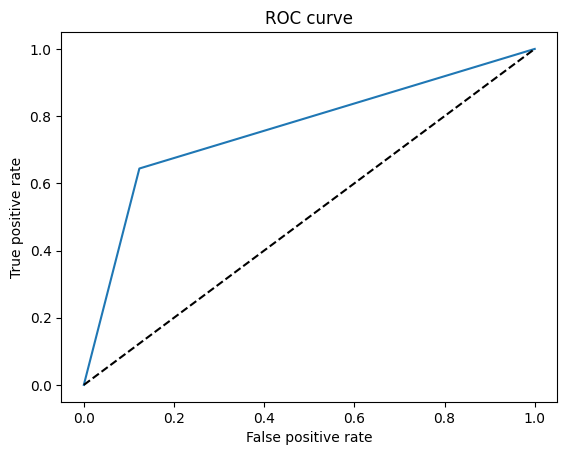

In [70]:
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

# Overfitting & regularization
In order to avoid overfitting, it is necessary to use additional techniques **(e.g. cross-validation, regularization, early stopping, pruning, or Bayesian priors).**


#### Regularization
is a way of finding a good **bias-variance tradeoff** by tuning the complexity of the model. It is a very useful method to handle:
 - collinearity (high correlation among features),
 - filter out noise from data, and
 - eventually prevent overfitting.
**The concept behind regularization is to introduce additional information (bias) to penalize extreme parameter weights.**

## k-fold cross-validation

The k-fold cross-validation procedure is a standard method for estimating the performance of a machine learning algorithm or configuration on a dataset.

A single run of the k-fold cross-validation procedure may result in a noisy estimate of model performance. Different splits of the data may result in very different results.

It is common to evaluate machine learning models on a dataset using k-fold cross-validation.

The k-fold cross-validation procedure divides a limited dataset into k non-overlapping folds. Each of the k folds is given an opportunity to be used as a held back test set, whilst all other folds collectively are used as a training dataset. A total of k models are fit and evaluated on the k hold-out test sets and the mean performance is reported.

Repeated k-fold cross-validation provides a way to improve the estimated performance of a machine learning model. This involves simply repeating the cross-validation procedure multiple times and reporting the mean result across all folds from all runs. This mean result is expected to be a more accurate estimate of the true unknown underlying mean performance of the model on the dataset, as calculated using the standard error.

In [71]:
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
# prepare the cross-validation procedure
cv = KFold(n_splits=10, random_state=20, shuffle=True)
# create and fitting  model
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
# evaluate model
scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
y_pred = model.predict(X_test)

print(accuracy_score(y_test,y_pred))
print("\n")
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.831 (0.005)
0.8277682298060398


[[5569  762]
 [ 641 1174]]


              precision    recall  f1-score   support

           0       0.90      0.88      0.89      6331
           1       0.61      0.65      0.63      1815

    accuracy                           0.83      8146
   macro avg       0.75      0.76      0.76      8146
weighted avg       0.83      0.83      0.83      8146



In [72]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score # to split the data
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score, roc_auc_score #To evaluate our model

from sklearn.model_selection import GridSearchCV

# Algorithmns models to be compared
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

LR: 0.864211 (0.007952)
LDA: 0.860159 (0.006621)
KNN: 0.863965 (0.007256)
CART: 0.826723 (0.007420)
NB: 0.825331 (0.009318)
RF: 0.881481 (0.006588)
SVM: 0.878739 (0.007362)
XGB: 0.891017 (0.006051)


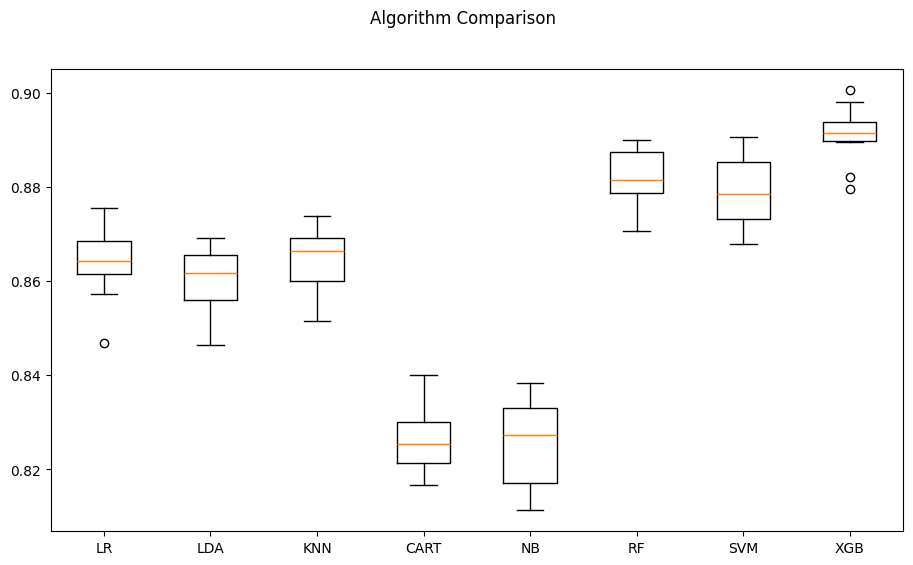

In [73]:
# to feed the random state
seed = 7

# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('XGB', XGBClassifier()))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
#scoring = 'recall'
for name, model in models:
        kfold = KFold(n_splits=10, shuffle=True, random_state=seed,)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)

# boxplot algorithm comparison
fig = plt.figure(figsize=(11,6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [ ]:
np.where(np.isnan(X_train)) #X_train.isna().any()

(array([], dtype=int64), array([], dtype=int64))

##Causal Machine Learning

In [ ]:
import dowhy
from dowhy import CausalModel

In [ ]:
# Simulate some credit risk data
np.random.seed(42)
n = 1000
X = np.random.normal(0, 1, size=(n, 3))  # 3 features: credit score, income, loan amount
T = np.random.binomial(1, p=0.5, size=(n,))  # Treatment: 0 (low interest rate), 1 (high interest rate)
Y = (X[:, 0] * 0.8 - X[:, 1] * 0.3 + T * 1.5 + np.random.normal(0, 1, size=n)) > 0  # Outcome: default or not
data = pd.DataFrame(np.column_stack([X, T, Y]), columns=["credit_score", "income", "loan_amount", "interest_rate", "default"])

In [ ]:
data.head()

,credit_score,income,loan_amount,interest_rate,default
0,0.496714,-0.138264,0.647689,1.0,1.0
1,1.523030,-0.234153,-0.234137,1.0,1.0
2,1.579213,0.767435,-0.469474,0.0,1.0
3,0.542560,-0.463418,-0.465730,1.0,1.0
4,0.241962,-1.913280,-1.724918,0.0,1.0


In [ ]:
data['interest_rate'].unique()

array([1., 0.])

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      32581 non-null  int64  
 1   person_income                   32581 non-null  float64
 2   person_emp_length               32581 non-null  float64
 3   loan_amnt                       32581 non-null  float64
 4   loan_int_rate                   32581 non-null  float64
 5   loan_percent_income             32581 non-null  float64
 6   cb_person_cred_hist_length      32581 non-null  int64  
 7   OTHER_DEBT                      32581 non-null  float64
 8   TIME_WITH_BANK                  32581 non-null  int64  
 9   LOAN_PERIOD in days             32581 non-null  float64
 10  person_home_ownership_MORTGAGE  32581 non-null  float64
 11  person_home_ownership_OTHER     32581 non-null  float64
 12  person_home_ownership_OWN       

In [ ]:
median_interest_rate = df['loan_int_rate'].median()
df['loan_int_rate1'] = (df['loan_int_rate'] >= median_interest_rate).astype(int)

In [ ]:
df = df.drop(['loan_int_rate'], axis=1)

In [ ]:
df['loan_status_1'] = df['loan_status_1'].astype(float)

In [ ]:
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      32581 non-null  int64  
 1   person_income                   32581 non-null  float64
 2   person_emp_length               32581 non-null  float64
 3   loan_amnt                       32581 non-null  float64
 4   loan_int_rate                   32581 non-null  float64
 5   loan_percent_income             32581 non-null  float64
 6   cb_person_cred_hist_length      32581 non-null  int64  
 7   OTHER_DEBT                      32581 non-null  float64
 8   TIME_WITH_BANK                  32581 non-null  int64  
 9   LOAN_PERIOD in days             32581 non-null  float64
 10  person_home_ownership_MORTGAGE  32581 non-null  float64
 11  person_home_ownership_OTHER     32581 non-null  float64
 12  person_home_ownership_OWN       

In [ ]:
# Define the SCM using DoWhy and specify the causal graph
common_causes=["person_age_cat","person_income_cat", "OTHER_DEBT_cat", "person_emp_length",
                "loan_amnt","loan_percent_income", "cb_person_cred_hist_length",
                "TIME_WITH_BANK", "LOAN_PERIOD in days","person_home_ownership_MORTGAGE",
                "person_home_ownership_OTHER","person_home_ownership_OWN","person_home_ownership_RENT",
                "loan_intent_DEBTCONSOLIDATION","loan_intent_EDUCATION","loan_intent_HOMEIMPROVEMENT",
                "loan_intent_MEDICAL","loan_intent_PERSONAL","loan_intent_VENTURE","loan_grade_A",
                "loan_grade_B","loan_grade_C","loan_grade_D","loan_grade_E","loan_grade_F","loan_grade_G","cb_person_default_on_file_N"]

model = CausalModel(
    data=df,
    treatment="loan_int_rate1",
    outcome="loan_status_1",
    common_causes=common_causes,
    instruments=None  # You can add instruments for IV methods
)

# Identify causal effect
identified_estimand = model.identify_effect()

# Estimate the effect using propensity score matching
estimate = model.estimate_effect(identified_estimand, method_name= "backdoor.linear_regression") #"backdoor.linear_regression""backdoor.propensity_score_matching"
print("Estimated Causal Effect:", estimate.value)

TypeError: OneHotEncoder.__init__() got an unexpected keyword argument 'sparse'

## Solve for the Above

### 1. Increase the Maximum Number of Iterations for the Logistic Regression Solver

In [ ]:
# Increase the number of iterations for the logistic regression solver
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_matching",
    method_params={
        "propensity_score_model": {
            "max_iter": 10000  # Increase the number of iterations
        }
    }
)

### Scale the Data

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      32581 non-null  int64  
 1   person_income                   32581 non-null  int64  
 2   person_emp_length               32581 non-null  float64
 3   loan_amnt                       32581 non-null  int64  
 4   loan_status                     32581 non-null  int64  
 5   loan_percent_income             32581 non-null  float64
 6   cb_person_cred_hist_length      32581 non-null  int64  
 7   OTHER_DEBT                      32581 non-null  float64
 8   TIME_WITH_BANK                  32581 non-null  int64  
 9   LOAN_PERIOD in days             32581 non-null  float64
 10  person_home_ownership_MORTGAGE  32581 non-null  float64
 11  person_home_ownership_OTHER     32581 non-null  float64
 12  person_home_ownership_OWN       

In [ ]:
from sklearn.preprocessing import StandardScaler

# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# Convert scaled data back to DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=df.columns)

common_causes=["person_age","person_income", "OTHER_DEBT", "person_emp_length",
               "loan_amnt","loan_percent_income","loan_status", "cb_person_cred_hist_length",
                "TIME_WITH_BANK", "LOAN_PERIOD in days","person_home_ownership_MORTGAGE",
                "person_home_ownership_OTHER","person_home_ownership_OWN","person_home_ownership_RENT",
                "loan_intent_DEBTCONSOLIDATION","loan_intent_EDUCATION","loan_intent_HOMEIMPROVEMENT",
                "loan_intent_MEDICAL","loan_intent_PERSONAL","loan_intent_VENTURE","loan_grade_A",
                "loan_grade_B","loan_grade_C","loan_grade_D","loan_grade_E","loan_grade_F","loan_grade_G","propensity_score"]


# Use scaled data for the causal model
model = CausalModel(
    data=scaled_df,
    treatment="loan_int_rate1",  # Binary treatment
    outcome="cb_person_default_on_file_N",  # Outcome
    common_causes=common_causes
)

# Re-identify and estimate the causal effect
identified_estimand = model.identify_effect()

# Estimate the causal effect using PSM with increased max_iter
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_matching",
    method_params={
        "propensity_score_model": {
            "max_iter": 10000  # Increase the number of iterations
        }
    }
)
print("Estimated Causal Effect:", estimate.value)


ERROR:dowhy.causal_estimator:Propensity score methods are applicable only for binary treatments


Exception: Propensity score methods are applicable only for binary treatments

In [74]:
df = df.rename(columns={'LOAN_PERIOD in days_cat': 'LOAN_PERIOD_cat'})

### Apply Domain Knowledge and Feature Importance

In [ ]:
dags = """digraph {

person_emp_length;
person_age;
cb_person_cred_hist_length;
cb_person_default_on_file_N;
TIME_WITH_BANK;
person_home_ownership_MORTGAGE;
loan_amnt;
loan_int_rate;
loan_grade_A;
loan_grade_C;
loan_grade_G;
loan_intent_VENTURE;
loan_intent_HOMEIMPROVEMENT;
person_income;
LOAN_PERIOD;
loan_status_1;



person_emp_length -> loan_amnt;
person_emp_length -> person_income;
person_emp_length -> person_home_ownership_MORTGAGE;
loan_amnt -> LOAN_PERIOD;
loan_int_rate -> loan_amnt;
loan_amnt -> loan_status_1;
loan_amnt -> loan_intent_VENTURE;
loan_amnt -> loan_intent_HOMEIMPROVEMENT;
cb_person_cred_hist_length -> loan_amnt;
cb_person_cred_hist_length -> loan_int_rate;
cb_person_cred_hist_length -> loan_status_1;
cb_person_cred_hist_length -> LOAN_PERIOD;
cb_person_cred_hist_length -> loan_grade_C;
cb_person_cred_hist_length -> loan_grade_G;
cb_person_cred_hist_length -> loan_grade_A;
loan_grade_A -> loan_status_1;
loan_grade_C -> loan_status_1;
loan_grade_G -> loan_status_1;
loan_int_rate -> loan_amnt;
loan_int_rate -> loan_status_1;
TIME_WITH_BANK -> loan_int_rate;
TIME_WITH_BANK -> loan_status_1;
TIME_WITH_BANK -> cb_person_cred_hist_length;
TIME_WITH_BANK -> loan_amnt;
TIME_WITH_BANK -> LOAN_PERIOD;
person_income -> loan_amnt;
person_income -> loan_status_1;
person_income -> LOAN_PERIOD;
person_age -> person_income;
person_age -> loan_int_rate;
person_age -> person_home_ownership_MORTGAGE;
person_age -> TIME_WITH_BANK;
cb_person_default_on_file_N -> loan_status_1;
person_age -> person_home_ownership_MORTGAGE;
person_emp_length -> person_home_ownership_MORTGAGE;
cb_person_cred_hist_length -> person_home_ownership_MORTGAGE;
TIME_WITH_BANK -> person_home_ownership_MORTGAGE;
loan_amnt -> person_home_ownership_MORTGAGE;
loan_int_rate -> person_home_ownership_MORTGAGE;
loan_grade_A -> person_home_ownership_MORTGAGE;
loan_grade_C -> person_home_ownership_MORTGAGE;
loan_grade_G -> person_home_ownership_MORTGAGE;
loan_intent_VENTURE -> person_home_ownership_MORTGAGE;
loan_intent_HOMEIMPROVEMENT -> person_home_ownership_MORTGAGE;
person_income -> person_home_ownership_MORTGAGE;
LOAN_PERIOD -> person_home_ownership_MORTGAGE;
person_home_ownership_MORTGAGE -> loan_status_1;
LOAN_PERIOD -> loan_status_1;
loan_intent_HOMEIMPROVEMENT -> loan_status_1;
loan_intent_VENTURE -> loan_status_1;
person_age -> loan_status_1;
person_emp_length -> loan_status_1;
}"""

In [ ]:
person_home_ownership_MORTGAGE -> loan_amnt;
person_home_ownership_MORTGAGE -> loan_status_1;
person_home_ownership_MORTGAGE -> cb_person_default_on_file_N;

ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...


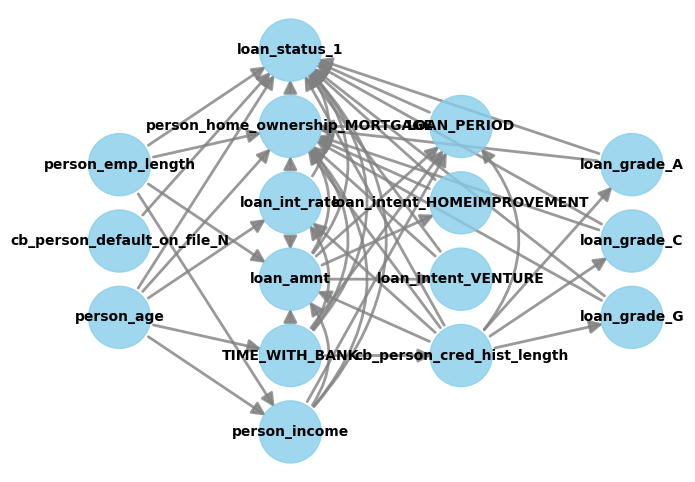

In [ ]:
treatment_col = 'person_home_ownership_MORTGAGE'
outcome_col = 'loan_status_1'
model=CausalModel(
    data = df,
    treatment=treatment_col,
    outcome=outcome_col,
    graph=dags)

model.view_model()

In [ ]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
                d                                                                                  ↪
─────────────────────────────────(E[loan_status_1|cb_person_cred_hist_length,person_income,person_ ↪
d[person_home_ownership_MORTGAGE]                                                                  ↪

↪                                                                                                  ↪
↪ emp_length,TIME_WITH_BANK,loan_amnt,loan_int_rate,loan_grade_G,loan_grade_A,loan_intent_VENTURE, ↪
↪                                                                                                  ↪

↪                                                                  
↪ LOAN_PERIOD,person_age,loan_intent_HOMEIMPROVEMENT,loan_grade_C])
↪                                                                  
Estimand assumption 1, Unconfoundedness: If U→{person_home_ownership_MORTGAGE} 

In [ ]:
common_causes = [
    "person_age", "person_income", "OTHER_DEBT", "person_emp_length",
    "loan_amnt", "loan_percent_income", "cb_person_cred_hist_length", "TIME_WITH_BANK",
    "person_home_ownership_MORTGAGE", "loan_intent_EDUCATION"
]

model = CausalModel(
    data=scaled_df,
    treatment="loan_int_rate1",
    outcome="cb_person_default_on_file_N",
    common_causes=common_causes
)


NameError: name 'scaled_df' is not defined

In [78]:
# ... (previous code) ...

# Use propensity score weighting with logistic regression for binary outcome
method = "backdoor.propensity_score_weighting"
desired_effect = "ate"
# Specify logistic regression as the model
estimate = model.estimate_effect(
    identified_estimand,
    method_name=method,
    target_units=desired_effect,
    method_params={"weighting_scheme":"ips_weight", "model_y": "LogisticRegression"}
)

# ... (rest of the code) ...


ERROR:dowhy.causal_estimator:No valid identified estimand available.


In [85]:
common_features=["person_age_cat","person_income_cat", "OTHER_DEBT_cat", "person_emp_length_cat",
                "loan_amnt_cat","loan_percent_income_cat", "cb_person_cred_hist_length_cat",
                "TIME_WITH_BANK_cat", "LOAN_PERIOD_cat","person_home_ownership",
                "loan_intent","loan_grade", "cb_person_default_on_file", "loan_int_rate_cat"]

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_home_ownership           32581 non-null  float64
 1   loan_intent                     32581 non-null  float64
 2   loan_grade                      32581 non-null  float64
 3   loan_status                     32581 non-null  float64
 4   cb_person_default_on_file       32581 non-null  float64
 5   person_age_cat                  32581 non-null  float64
 6   person_income_cat               32581 non-null  float64
 7   person_emp_length_cat           32581 non-null  float64
 8   loan_amnt_cat                   32581 non-null  float64
 9   loan_int_rate_cat               32581 non-null  float64
 10  loan_percent_income_cat         32581 non-null  float64
 11  cb_person_cred_hist_length_cat  32581 non-null  float64
 12  OTHER_DEBT_cat                  

In [87]:

# Define the treatment and outcome variables
#treatment_variable = "person_home_ownership_MORTGAGE"
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

outcome_variable = "loan_status"

# Perform causal inference using DoWhy for each feature
for feature in common_features:
    print(f"\nCausal Inference for {feature} as the treatment variable:")



    # Check if the treatment variable is binary
    #is_binary = df[feature].nunique() == 2
    is_binary = df.loc[:, feature].nunique() == 2
    # Select the appropriate method_name based on binary status
    method_name = ( "backdoor.linear_regression"
        #"backdoor.propensity_score_weighting" if is_binary else "backdoor.linear_regression"
    )

    print(f"Selected method: {method_name}")
  # Create the CausalModel
    model = CausalModel(
    data=df,
    treatment=feature,         #treatment_variable,
    outcome=outcome_variable,
    #common_causes = [
   # "person_age", "person_income", "OTHER_DEBT", "person_emp_length",
    #"loan_amnt", "loan_percent_income", "cb_person_cred_hist_length", "TIME_WITH_BANK",
    # "loan_intent_EDUCATION"
      #],  # Add your confounders
    common_causes=[col for col in common_features if col != feature])

    # Identify the estimand
    identified_estimand = model.identify_effect()

    # Estimate the causal effect
    estimate = model.estimate_effect(
    identified_estimand,
    method_name=method_name,  #backdoor.linear_regression  backdoor.propensity_score_weighting
    target_units="ate",
    #method_params={
        #"weighting_scheme": "ips_weight",
        #"model_y": LogisticRegression()}
    method_params={
            "weighting_scheme": "ips_weight" if is_binary else None,
            "model_y": LogisticRegression() if not is_binary else None})  #RandomForestRegressor() RandomForestClassifier()

    # Refute the estimate
    refuted_estimate = model.refute_estimate(estimand=identified_estimand,
     estimate=estimate,
    method_name="data_subset_refuter",
    subset_fraction=0.5)

      # Print the results
    print(f'Estimated Average Treatment Effect:', estimate.value)
    print("Causal Estimate:", estimate)
    print("Refuted Estimate:", refuted_estimate)



Causal Inference for person_age_cat as the treatment variable:
Selected method: backdoor.linear_regression


Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (con

Estimated Average Treatment Effect: -0.015308148620876594
Causal Estimate: *** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                                                                          ↪
─────────────────(E[loan_status|loan_intent,person_income_cat,loan_percent_income_cat,person_emp_l ↪
d[person_age_cat]                                                                                  ↪

↪                                                                                                  ↪
↪ ength_cat,loan_grade,OTHER_DEBT_cat,cb_person_default_on_file,loan_int_rate_cat,person_home_owne ↪
↪                                                                                                  ↪

↪                                                                                        
↪ rship,LOAN_PERIOD_cat,loan_amnt_cat,TIME_WITH_BANK_cat,cb_person_cre

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (con

Estimated Average Treatment Effect: 0.10946933951705057
Causal Estimate: *** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                                                                         ↪
────────────────────(E[loan_status|loan_intent,loan_percent_income_cat,person_age_cat,person_emp_l ↪
d[person_income_cat]                                                                               ↪

↪                                                                                                  ↪
↪ ength_cat,loan_grade,OTHER_DEBT_cat,cb_person_default_on_file,loan_int_rate_cat,person_home_owne ↪
↪                                                                                                  ↪

↪                                                                                        
↪ rship,LOAN_PERIOD_cat,loan_amnt_cat,TIME_WITH_BANK_cat,cb_person_cred_

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (con

Estimated Average Treatment Effect: -0.061832737550696903
Causal Estimate: *** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                                                                          ↪
─────────────────(E[loan_status|loan_intent,person_income_cat,loan_percent_income_cat,person_age_c ↪
d[OTHER_DEBT_cat]                                                                                  ↪

↪                                                                                                  ↪
↪ at,person_emp_length_cat,loan_grade,cb_person_default_on_file,loan_int_rate_cat,person_home_owne ↪
↪                                                                                                  ↪

↪                                                                                        
↪ rship,LOAN_PERIOD_cat,loan_amnt_cat,TIME_WITH_BANK_cat,cb_person_cre

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (con

Estimated Average Treatment Effect: -0.0020887632685447632
Causal Estimate: *** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                                                                                       ↪
────────────────────────(E[loan_status|loan_intent,person_income_cat,loan_percent_income_cat,perso ↪
d[person_emp_length_cat]                                                                           ↪

↪                                                                                                  ↪
↪ n_age_cat,loan_grade,OTHER_DEBT_cat,cb_person_default_on_file,loan_int_rate_cat,person_home_owne ↪
↪                                                                                                  ↪

↪                                                                                        
↪ rship,LOAN_PERIOD_cat,loan_amnt_cat,TIME_WITH_BANK_cat,cb_person_cr

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (con

Estimated Average Treatment Effect: 0.12502691975697589
Causal Estimate: *** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                                                                           ↪
────────────────(E[loan_status|loan_intent,person_income_cat,loan_percent_income_cat,person_age_ca ↪
d[loan_amnt_cat]                                                                                   ↪

↪                                                                                                  ↪
↪ t,person_emp_length_cat,loan_grade,OTHER_DEBT_cat,cb_person_default_on_file,loan_int_rate_cat,pe ↪
↪                                                                                                  ↪

↪                                                                                        
↪ rson_home_ownership,LOAN_PERIOD_cat,TIME_WITH_BANK_cat,cb_person_cred_

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (con

Estimated Average Treatment Effect: -0.18762118651041526
Causal Estimate: *** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                                      ↪
──────────────────────────(E[loan_status|loan_intent,person_income_cat,person_age_cat,person_emp_l ↪
d[loan_percent_income_cat]                                                                         ↪

↪                                                                                                  ↪
↪ ength_cat,loan_grade,OTHER_DEBT_cat,cb_person_default_on_file,loan_int_rate_cat,person_home_owne ↪
↪                                                                                                  ↪

↪                                                                                        
↪ rship,LOAN_PERIOD_cat,loan_amnt_cat,TIME_WITH_BANK_cat,cb_person_cred

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (con

Estimated Average Treatment Effect: -0.0877451096944345
Causal Estimate: *** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
                d                                                                                  ↪
─────────────────────────────────(E[loan_status|loan_intent,person_income_cat,loan_percent_income_ ↪
d[cb_person_cred_hist_length_cat]                                                                  ↪

↪                                                                                                  ↪
↪ cat,person_age_cat,person_emp_length_cat,loan_grade,OTHER_DEBT_cat,cb_person_default_on_file,loa ↪
↪                                                                                                  ↪

↪                                                                                        
↪ n_int_rate_cat,person_home_ownership,LOAN_PERIOD_cat,loan_amnt_cat,TIM

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (con

Estimated Average Treatment Effect: -0.07935781270765008
Causal Estimate: *** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
          d                                                                                        ↪
─────────────────────(E[loan_status|loan_intent,person_income_cat,loan_percent_income_cat,person_a ↪
d[TIME_WITH_BANK_cat]                                                                              ↪

↪                                                                                                  ↪
↪ ge_cat,person_emp_length_cat,OTHER_DEBT_cat,cb_person_default_on_file,loan_int_rate_cat,person_h ↪
↪                                                                                                  ↪

↪                                                                                        
↪ ome_ownership,LOAN_PERIOD_cat,loan_amnt_cat,loan_grade,cb_person_cred

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (con

Estimated Average Treatment Effect: -0.07064412716491916
Causal Estimate: *** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                                                                          ↪
──────────────────(E[loan_status|loan_intent,person_income_cat,loan_percent_income_cat,person_age_ ↪
d[LOAN_PERIOD_cat]                                                                                 ↪

↪                                                                                                  ↪
↪ cat,person_emp_length_cat,loan_grade,OTHER_DEBT_cat,cb_person_default_on_file,loan_int_rate_cat, ↪
↪                                                                                                  ↪

↪                                                                                        
↪ person_home_ownership,loan_amnt_cat,TIME_WITH_BANK_cat,cb_person_cred

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (con

Estimated Average Treatment Effect: -0.10294780172241838
Causal Estimate: *** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                                                                                       ↪
────────────────────────(E[loan_status|loan_intent,person_income_cat,loan_percent_income_cat,perso ↪
d[person_home_ownership]                                                                           ↪

↪                                                                                                  ↪
↪ n_age_cat,person_emp_length_cat,loan_grade,OTHER_DEBT_cat,cb_person_default_on_file,loan_int_rat ↪
↪                                                                                                  ↪

↪                                                                                        
↪ e_cat,LOAN_PERIOD_cat,loan_amnt_cat,TIME_WITH_BANK_cat,cb_person_cred

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (con

Estimated Average Treatment Effect: -0.14454343729266728
Causal Estimate: *** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                                                                            ↪
─────────────(E[loan_status|person_income_cat,loan_percent_income_cat,person_age_cat,person_emp_le ↪
d[loanᵢₙₜₑₙₜ]                                                                                      ↪

↪                                                                                                  ↪
↪ ngth_cat,loan_grade,OTHER_DEBT_cat,cb_person_default_on_file,loan_int_rate_cat,person_home_owner ↪
↪                                                                                                  ↪

↪                                                                                       
↪ ship,LOAN_PERIOD_cat,loan_amnt_cat,TIME_WITH_BANK_cat,cb_person_cred_h

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (con

Estimated Average Treatment Effect: -0.17576664707717143
Causal Estimate: *** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                                                                            ↪
─────────────(E[loan_status|loan_intent,person_income_cat,loan_percent_income_cat,person_age_cat,p ↪
d[loan_grade]                                                                                      ↪

↪                                                                                                  ↪
↪ erson_emp_length_cat,OTHER_DEBT_cat,cb_person_default_on_file,loan_int_rate_cat,person_home_owne ↪
↪                                                                                                  ↪

↪                                                                                        
↪ rship,LOAN_PERIOD_cat,loan_amnt_cat,TIME_WITH_BANK_cat,cb_person_cred

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (con

Estimated Average Treatment Effect: 0.009960816883347073
Causal Estimate: *** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
             d                                                                                     ↪
────────────────────────────(E[loan_status|loan_intent,person_income_cat,loan_percent_income_cat,p ↪
d[cb_person_default_on_file]                                                                       ↪

↪                                                                                                  ↪
↪ erson_age_cat,person_emp_length_cat,loan_grade,OTHER_DEBT_cat,loan_int_rate_cat,person_home_owne ↪
↪                                                                                                  ↪

↪                                                                                        
↪ rship,LOAN_PERIOD_cat,loan_amnt_cat,TIME_WITH_BANK_cat,cb_person_cred

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (con

Estimated Average Treatment Effect: 0.007201707475806868
Causal Estimate: *** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                                                                         ↪
────────────────────(E[loan_status|loan_intent,person_income_cat,loan_percent_income_cat,person_ag ↪
d[loan_int_rate_cat]                                                                               ↪

↪                                                                                                  ↪
↪ e_cat,person_emp_length_cat,loan_grade,OTHER_DEBT_cat,cb_person_default_on_file,person_home_owne ↪
↪                                                                                                  ↪

↪                                                                                        
↪ rship,LOAN_PERIOD_cat,loan_amnt_cat,TIME_WITH_BANK_cat,cb_person_cred

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


In [88]:
intervened_data = df.copy()
intervened_data["person_home_ownership"] = 1

outcome_variable = "loan_status"

# Perform causal inference using DoWhy for each feature
for feature in common_features:
    print(f"\nCausal Inference for {feature} as the treatment variable:")



    # Check if the treatment variable is binary
    #is_binary = df[feature].nunique() == 2
    is_binary = df.loc[:, feature].nunique() == 2
    # Select the appropriate method_name based on binary status
    method_name = (
        "backdoor.propensity_score_weighting" if is_binary else "backdoor.linear_regression"
    )

    print(f"Selected method: {method_name}")
  # Create the CausalModel

# Step 1: Create a new causal model with the intervened dataset
    intervened_model = CausalModel(
    data=intervened_data,
    treatment=feature,
    #treatment="person_home_ownership_MORTGAGE",
    #outcome="loan_status_1",
    outcome=outcome_variable,
    common_causes=["person_age", "person_income"]
    )

# Step 2: Estimate the causal effect using the intervened model
    intervention_effect = intervened_model.estimate_effect(
    identified_estimand=identified_estimand,
    method_name="backdoor.linear_regression",  # Example estimation method
    target_units="ate",  # Average treatment effect
    method_params={
        "weighting_scheme": "ips_weight"
    }
    )

# Print the results
    print("Causal Effect After Intervention:", intervention_effect.value)


  #Counterfactual Estimate
    counterfactual_outcome = intervened_data[outcome_variable].mean()
# Print the results
#print("Counterfactual Estimate:", counterfactual_estimate)
    print(f"Counterfactual Outcome after intervention: {counterfactual_outcome}")

2 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
2 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.



Causal Inference for person_age_cat as the treatment variable:
Selected method: backdoor.linear_regression
Causal Effect After Intervention: -0.0002441408591669636
Counterfactual Outcome after intervention: 0.21816396059052823

Causal Inference for person_income_cat as the treatment variable:
Selected method: backdoor.linear_regression


Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
2 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
2 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.


Causal Effect After Intervention: -0.0002441408591669636
Counterfactual Outcome after intervention: 0.21816396059052823

Causal Inference for OTHER_DEBT_cat as the treatment variable:
Selected method: backdoor.linear_regression
Causal Effect After Intervention: -0.0002441408591669636
Counterfactual Outcome after intervention: 0.21816396059052823

Causal Inference for person_emp_length_cat as the treatment variable:
Selected method: backdoor.linear_regression


Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
2 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
2 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.


Causal Effect After Intervention: -0.0002441408591669636
Counterfactual Outcome after intervention: 0.21816396059052823

Causal Inference for loan_amnt_cat as the treatment variable:
Selected method: backdoor.linear_regression
Causal Effect After Intervention: -0.0002441408591669636
Counterfactual Outcome after intervention: 0.21816396059052823

Causal Inference for loan_percent_income_cat as the treatment variable:
Selected method: backdoor.linear_regression


Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
2 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
2 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.


Causal Effect After Intervention: -0.0002441408591669636
Counterfactual Outcome after intervention: 0.21816396059052823

Causal Inference for cb_person_cred_hist_length_cat as the treatment variable:
Selected method: backdoor.linear_regression
Causal Effect After Intervention: -0.0002441408591669636
Counterfactual Outcome after intervention: 0.21816396059052823

Causal Inference for TIME_WITH_BANK_cat as the treatment variable:
Selected method: backdoor.linear_regression


Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
2 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
2 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.


Causal Effect After Intervention: -0.0002441408591669636
Counterfactual Outcome after intervention: 0.21816396059052823

Causal Inference for LOAN_PERIOD_cat as the treatment variable:
Selected method: backdoor.linear_regression
Causal Effect After Intervention: -0.0002441408591669636
Counterfactual Outcome after intervention: 0.21816396059052823

Causal Inference for person_home_ownership as the treatment variable:
Selected method: backdoor.linear_regression


Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
2 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
2 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.


Causal Effect After Intervention: -0.0002441408591669636
Counterfactual Outcome after intervention: 0.21816396059052823

Causal Inference for loan_intent as the treatment variable:
Selected method: backdoor.linear_regression
Causal Effect After Intervention: -0.0002441408591669636
Counterfactual Outcome after intervention: 0.21816396059052823

Causal Inference for loan_grade as the treatment variable:
Selected method: backdoor.linear_regression


Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
2 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
2 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.


Causal Effect After Intervention: -0.0002441408591669636
Counterfactual Outcome after intervention: 0.21816396059052823

Causal Inference for cb_person_default_on_file as the treatment variable:
Selected method: backdoor.propensity_score_weighting
Causal Effect After Intervention: -0.0002441408591669636
Counterfactual Outcome after intervention: 0.21816396059052823

Causal Inference for loan_int_rate_cat as the treatment variable:
Selected method: backdoor.linear_regression
Causal Effect After Intervention: -0.0002441408591669636
Counterfactual Outcome after intervention: 0.21816396059052823


Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


In [89]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

# Create intervened_data
intervened_data = df.copy()

for feature in common_features:
    if pd.api.types.is_numeric_dtype(df[feature]):
        if set(df[feature].unique()) == {0, 1}:
            # Binary variable: Set all values to 1
            intervened_data[feature] = 1
        else:
            # Numeric/Float variable: Set all values to the square of the mean
            mean_squared = df[feature].mean() ** 2
            intervened_data[feature] = mean_squared
    else:
        raise ValueError(f"Feature '{feature}' is not numeric or binary.")

    is_binary = df.loc[:, feature].nunique() == 2
    # Select the appropriate method_name based on binary status
    method_name = (
        "backdoor.propensity_score_weighting" if is_binary else "backdoor.linear_regression"
    )


# Define causal model with the intervened data
    intervened_model = CausalModel(
    data=intervened_data,
    treatment=feature,
    outcome="loan_status_1",
    common_causes=[col for col in common_features if col != feature]
    )

# Identify the causal estimand
    identified_estimand = intervened_model.identify_effect()

# Estimate the causal effect using the intervened model
    intervention_effect = intervened_model.estimate_effect(
    identified_estimand=identified_estimand,
    method_name= method_name, # "backdoor.linear_regression",  # Example estimation method
    target_units="ate",  # Average treatment effect
    #method_params={
    #    "weighting_scheme": "ips_weight"
     #  }
    method_params={
            "weighting_scheme": "ips_weight" if is_binary else None,
            "model_y": LogisticRegression() if not is_binary else None})

# Counterfactual outcome calculation
    #counterfactual_outcome = intervened_data["loan_status_1"].mean()
    #counterfactual_outcome = calculate_counterfactual_outcome(intervened_data, feature, intervened_data[feature])
    # Print results
    print(f"\nCausal Inference for {feature} as the treatment variable:")
    print(f"Selected method: {method_name}")
    print("Causal Effect After Intervention:", intervention_effect.value)
    #print(f"Counterfactual Outcome After Intervention: {counterfactual_outcome}")

1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.


KeyError: 'loan_status_1'

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Assuming 'dataset' contains your data and 'treatment_col' and 'outcome_col' are defined

# Split data into treatment and control groups
treatment_group = df[df[treatment_col] == 1]
control_group = df[df[treatment_col] == 0]

# Get predicted outcomes for treatment and control groups
treatment_outcomes = model.estimate_effect(identified_estimand, method_name="backdoor.propensity_score_matching",
                                             target_units="ate").value  # or other method
control_outcomes = model.estimate_effect(identified_estimand, method_name="backdoor.propensity_score_matching",
                                            target_units="atc").value  # or other method

# Combine predicted outcomes for both groups
predicted_outcomes = np.concatenate([treatment_outcomes, control_outcomes])

# Get true outcomes for both groups
true_outcomes = np.concatenate([treatment_group[outcome_col], control_group[outcome_col]])

# Calculate accuracy score
accuracy = accuracy_score(true_outcomes, predicted_outcomes.round())
print(f"Accuracy: {accuracy}")

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_outcomes, predicted_outcomes.round())
print(f"Confusion Matrix:\n{conf_matrix}")

# Generate classification report
class_report = classification_report(true_outcomes, predicted_outcomes.round())
print(f"Classification Report:\n{class_report}")

ValueError: zero-dimensional arrays cannot be concatenated

In [ ]:
from sklearn.metrics import accuracy_score

# ... (your causal model code) ...

# Predict treatment effects
treatment_effects = model.estimate_effect(identified_estimand, method_name="backdoor.propensity_score_matching").value

# Convert treatment effects to binary predictions
predicted_outcomes = (treatment_effects < 0.5).astype(int)  # Example threshold

# Calculate accuracy
accuracy = accuracy_score(df['loan_status_1'], predicted_outcomes)
print(f"Accuracy: {accuracy}")

InvalidParameterError: The 'y_pred' parameter of accuracy_score must be an array-like or a sparse matrix. Got 1 instead.

## Gradient Boosting Classifier Causal Model


In [ ]:
# Import necessary libraries
import numpy as np
from econml.dml import CausalForestDML
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
np.random.seed(42)

# Prepare the data
X = df.drop('loan_status_1', axis=1).values
Y = df['loan_status_1'].values
T = df['loan_intent_HOMEIMPROVEMENT'].values

# Train-Test Split
X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(
    X, T, Y, test_size=0.2, random_state=42
)

# Initialize the models for the outcome and treatment
model_y = GradientBoostingRegressor(random_state=42)
model_t = GradientBoostingClassifier(random_state=42)

# Initialize the CausalForestDML estimator
est = CausalForestDML(
    model_y=model_y,
    model_t=model_t,
    discrete_treatment=True,
    random_state=42
)

# Fit the model on the training data
est.fit(Y_train, T_train, X=X_train)

# Estimate the treatment effect on the test data
treatment_effects = est.effect(X_test)

# Print the average treatment effect
ate = np.mean(treatment_effects)
print(f'Average Treatment Effect (ATE): {ate}')


Average Treatment Effect (ATE): 3476.1923948600106


In [ ]:
# Import necessary libraries
import numpy as np
from econml.dml import CausalForestDML
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
#from sklearn.model_selection import train_test_split

# Assume X, T, and Y are your features, treatment, and outcome variables respectively
X = df.drop('loan_status_1', axis = 1).values  #loan_status cb_person_default_on_file_N
Y = df['loan_status_1'].values
T = df['person_home_ownership_MORTGAGE'].values

# Spliting X and y into train and test version
# Train-Test Split
X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(X, T, Y, test_size=0.2, random_state=42)

# Initialize the models for the outcome and treatment
model_y = GradientBoostingRegressor()
model_t = GradientBoostingClassifier()   #GradientBoostingRegressor for descrete treatment/ GradientBoostingClassifier for continu...

# Initialize the CausalForestDML estimator
est = CausalForestDML(model_y=model_y, model_t=model_t, discrete_treatment=True)

# Fit the model on the training data
est.fit(Y_train, T_train, X=X_train)

# Estimate the treatment effect on the test data
treatment_effects = est.effect(X_test)

# Print the average treatment effect
ate = np.mean(treatment_effects)
print(f'Average Treatment Effect (ATE): {ate}')


Average Treatment Effect (ATE): -14.209097908127362


In [ ]:
#Output some results
print("Estimated Treatment Effects for Test Set:")
print(treatment_effects[:10])

Estimated Treatment Effects for Test Set:
[  754.71023487 -1703.60275058  1011.25275371 -2544.20133155
  1779.47280151 -2175.05954531  -518.73416462  -222.00825819
   414.38630093  1122.34085776]


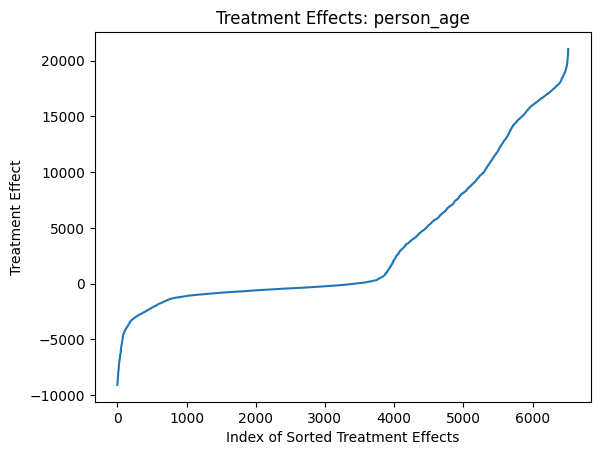

In [ ]:
# Flatten and sort the treatment_effects
treatment_effects_flat = treatment_effects.flatten()
treatment_effects_sorted = np.sort(treatment_effects_flat)
# Create the x-axis values (indices of the sorted effects)
x_values = np.arange(len(treatment_effects_sorted))
# Plot the line graph
plt.plot(x_values, treatment_effects_sorted)
plt.xlabel("Index of Sorted Treatment Effects")
plt.ylabel("Treatment Effect")
plt.title("Treatment Effects: person_age")
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score



# Convert predicted treatment effects to binary labels (e.g., >0 means treatment is favorable)
binary_treatment_preds = (treatment_effects < -700).astype(int)

# Compare predicted binary outcomes with true binary outcomes (Y_test)
conf_matrix = confusion_matrix(Y_test, binary_treatment_preds)
accuracy = accuracy_score(Y_test, binary_treatment_preds)

print("Confusion Matrix:")
print(conf_matrix)
print("\nAccuracy of Treatment Prediction:", accuracy)

print("\nAccuracy of Treatment Prediction:",classification_report(Y_test, binary_treatment_preds))

Confusion Matrix:
[[3943 1129]
 [ 780  665]]

Accuracy of Treatment Prediction: 0.7070738069663955

Accuracy of Treatment Prediction:               precision    recall  f1-score   support

         0.0       0.83      0.78      0.81      5072
         1.0       0.37      0.46      0.41      1445

    accuracy                           0.71      6517
   macro avg       0.60      0.62      0.61      6517
weighted avg       0.73      0.71      0.72      6517



Text(0.5, 1.0, 'ROC curve person home ownership MORTGAGE')

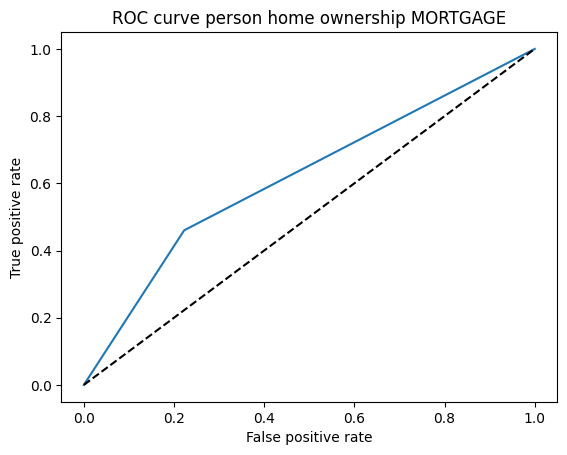

In [ ]:
roc_curve(Y_test, binary_treatment_preds)
fpr, tpr, thresholds = roc_curve(Y_test, binary_treatment_preds)
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve person home ownership MORTGAGE')

In [ ]:
# Conditional Average Treatment Effect for a subset where feature 1 > 0
CATE_feature1_positive = np.mean(treatment_effects[X_test[:, 0] > 0])
print(f"Conditional Average Treatment Effect (CATE) for Feature 1 > 0: {CATE_feature1_positive}")

Conditional Average Treatment Effect (CATE) for Feature 1 > 0: -0.042959710036166866


In [ ]:
# Assuming 'est' is your fitted CausalForest object
summary_output = est.summary()

# Print the summary to the console:
print(summary_output)

# OR, display the summary nicely within a Jupyter Notebook cell:
from IPython.display import display
display(summary_output)

Population summary results are available only if `cache_values=True` at fit time!
        Doubly Robust ATE on Training Data Results        
    point_estimate stderr  zstat  pvalue ci_lower ci_upper
----------------------------------------------------------
ATE         -0.045  0.001 -34.241    0.0   -0.048   -0.042
     Doubly Robust ATT(T=0) on Training Data Results      
    point_estimate stderr  zstat  pvalue ci_lower ci_upper
----------------------------------------------------------
ATT         -0.085  0.002 -51.956    0.0   -0.089   -0.082
    Doubly Robust ATT(T=1) on Training Data Results     
    point_estimate stderr zstat pvalue ci_lower ci_upper
--------------------------------------------------------
ATT          0.013  0.002 6.139    0.0    0.009    0.016
--------------------------------------------------------


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATE,-0.045,0.001,-34.241,0.0,-0.048,-0.042
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATT,-0.085,0.002,-51.956,0.0,-0.089,-0.082
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATT,0.013,0.002,6.139,0.0,0.009,0.016


In [ ]:
# Assess performance on specific subgroups (e.g., X[:, 0] > 0)
from sklearn.metrics import mean_squared_error
subgroup_effects = est.effect(X_test[X_test[:, 0] > 0])
mse_subgroup = mean_squared_error(Y_test[X_test[:, 0] > 0], subgroup_effects)
print("Generalizability:-MSE for Subgroup with X[:, 0] > 0:", mse_subgroup)


Generalizability:-MSE for Subgroup with X[:, 0] > 0: 0.33301576068873695


In [ ]:
df['loan_status_binary'] = (df['loan_status']).astype(int)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      32581 non-null  int64  
 1   person_income                   32581 non-null  float64
 2   person_emp_length               32581 non-null  float64
 3   loan_amnt                       32581 non-null  float64
 4   loan_int_rate                   32581 non-null  float64
 5   loan_status                     32581 non-null  int64  
 6   loan_percent_income             32581 non-null  float64
 7   cb_person_cred_hist_length      32581 non-null  int64  
 8   OTHER_DEBT                      32581 non-null  float64
 9   TIME_WITH_BANK                  32581 non-null  int64  
 10  LOAN_PERIOD                     32581 non-null  float64
 11  person_home_ownership_MORTGAGE  32581 non-null  float64
 12  person_home_ownership_OTHER     

## K Neighbour Classifier

In [ ]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split
from econml.dml import CausalForestDML
from sklearn.metrics import mean_squared_error

# Assume X, T, and Y are your features, treatment, and outcome variables respectively
X = df.drop('loan_status_1', axis = 1).values  #loan_status cb_person_default_on_file_N
Y = df['loan_status_1'].values
T = df['person_home_ownership_MORTGAGE'].values

# Spliting X and y into train and test version
# Train-Test Split
X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(X, T, Y, test_size=0.2, random_state=42)

# Define K-Neighbors Classifier for treatment and outcome models
model_t = KNeighborsClassifier(n_neighbors=5)  # For treatment model
model_y = KNeighborsRegressor(n_neighbors=5)  # For outcome model

# Define CausalForestDML model using KNN
causal_model = CausalForestDML(
    model_t=model_t,
    model_y=model_y,
    discrete_treatment=True
)

# Fit causal model
causal_model.fit(Y_train, T_train, X=X_train)

# Estimate treatment effects on test data
treatment_effects = causal_model.effect(X_test)

# Evaluate results
print("Estimated Treatment Effects (First 5):", treatment_effects[:5])
print("Average Treatment Effect (ATE):", np.mean(treatment_effects))

# Measure generalization on unseen data
predictions = causal_model.effect(X_test)
mse = mean_squared_error(T_test, predictions)
print("Mean Squared Error of Treatment Effects:", mse)


Estimated Treatment Effects (First 5): [-0.25014863 -0.01596233  0.03342009 -0.80939141 -0.13129401]
Average Treatment Effect (ATE): -0.07169723140423315
Mean Squared Error of Treatment Effects: 0.4994640274603657


In [ ]:
#Output some results
print("Estimated Treatment Effects for Test Set:")
print(treatment_effects[:10])

Estimated Treatment Effects for Test Set:
[-0.25014863 -0.01596233  0.03342009 -0.80939141 -0.13129401 -0.75933282
 -0.02966748  0.02011033  0.02373708  0.03081589]


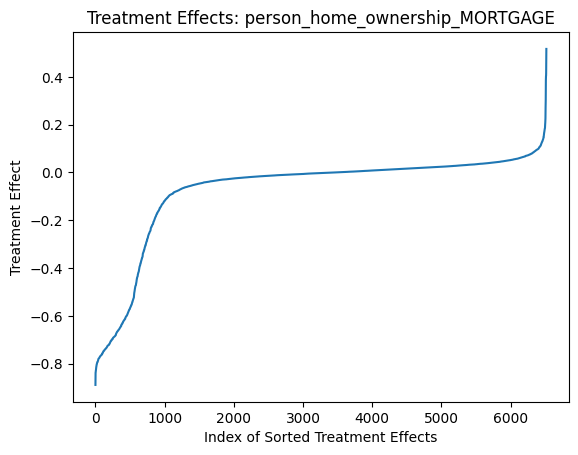

In [ ]:
# Flatten and sort the treatment_effects
treatment_effects_flat = treatment_effects.flatten()
treatment_effects_sorted = np.sort(treatment_effects_flat)
# Create the x-axis values (indices of the sorted effects)
x_values = np.arange(len(treatment_effects_sorted))
# Plot the line graph
plt.plot(x_values, treatment_effects_sorted)
plt.xlabel("Index of Sorted Treatment Effects")
plt.ylabel("Treatment Effect")
plt.title("Treatment Effects: person_home_ownership_MORTGAGE")
plt.show()

In [ ]:
index_of_interest = 1445  # The index you're interested in

# Retrieve the value from treatment_effects_sorted
y_value = treatment_effects_sorted[index_of_interest]

print(f"The value on the y-axis for Index {index_of_interest} is: {y_value}")

The value on the y-axis for Index 1445 is: -0.050166959657207494


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score



# Convert predicted treatment effects to binary labels (e.g., >0 means treatment is favorable)
binary_treatment_preds = (treatment_effects < -0.0418420850543027).astype(int)

# Compare predicted binary outcomes with true binary outcomes (Y_test)
conf_matrix = confusion_matrix(Y_test, binary_treatment_preds)
accuracy = accuracy_score(Y_test, binary_treatment_preds)

print("Confusion Matrix:")
print(conf_matrix)
print("\nAccuracy of Treatment Prediction:", accuracy)

print("\nAccuracy of Treatment Prediction:",classification_report(Y_test, binary_treatment_preds))

Confusion Matrix:
[[4349  723]
 [ 603  842]]

Accuracy of Treatment Prediction: 0.7965321466932638

Accuracy of Treatment Prediction:               precision    recall  f1-score   support

         0.0       0.88      0.86      0.87      5072
         1.0       0.54      0.58      0.56      1445

    accuracy                           0.80      6517
   macro avg       0.71      0.72      0.71      6517
weighted avg       0.80      0.80      0.80      6517



Text(0.5, 1.0, 'ROC curve person home ownership MORTGAGE')

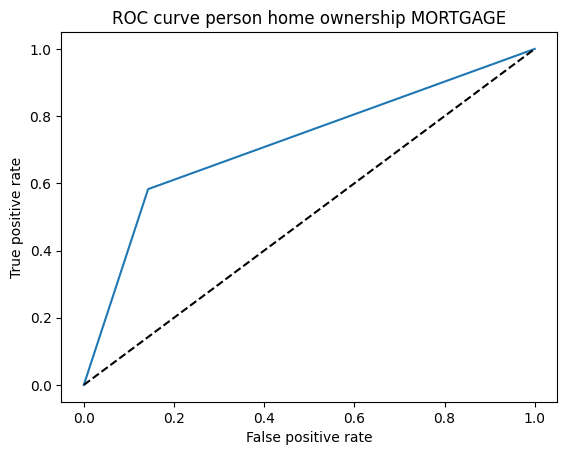

In [ ]:
roc_curve(Y_test, binary_treatment_preds)
fpr, tpr, thresholds = roc_curve(Y_test, binary_treatment_preds)
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve person home ownership MORTGAGE')

In [ ]:
roc_auc = roc_auc_score(Y_test, binary_treatment_preds)

# Print AUC
print("AUC:", roc_auc)

AUC: 0.7200758216628644


In [ ]:
# Conditional Average Treatment Effect for a subset where feature 1 > 0
CATE_feature1_positive = np.mean(treatment_effects[X_test[:, 0] > 0])
print(f"Conditional Average Treatment Effect (CATE) for Feature 1 > 0: {CATE_feature1_positive}")

Conditional Average Treatment Effect (CATE) for Feature 1 > 0: -0.07169723140423315


In [ ]:
# Assuming 'est' is your fitted CausalForest object
summary_output = causal_model.summary()

# Print the summary to the console:
print(summary_output)

# OR, display the summary nicely within a Jupyter Notebook cell:
from IPython.display import display
display(summary_output)

Population summary results are available only if `cache_values=True` at fit time!
        Doubly Robust ATE on Training Data Results       
    point_estimate stderr zstat  pvalue ci_lower ci_upper
---------------------------------------------------------
ATE         -0.147   0.05 -2.952  0.003   -0.244   -0.049
     Doubly Robust ATT(T=0) on Training Data Results     
    point_estimate stderr zstat  pvalue ci_lower ci_upper
---------------------------------------------------------
ATT          -0.14  0.039 -3.569    0.0   -0.217   -0.063
     Doubly Robust ATT(T=1) on Training Data Results     
    point_estimate stderr zstat  pvalue ci_lower ci_upper
---------------------------------------------------------
ATT         -0.156  0.107 -1.465  0.143   -0.366    0.053
---------------------------------------------------------


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATE,-0.147,0.05,-2.952,0.003,-0.244,-0.049
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATT,-0.14,0.039,-3.569,0.0,-0.217,-0.063
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATT,-0.156,0.107,-1.465,0.143,-0.366,0.053


## Generalisability

In [ ]:
# Assess performance on specific subgroups (e.g., X[:, 0] > 0)
from sklearn.metrics import mean_squared_error
subgroup_effects = est.predict(X_test[X_test[:, 0] > 0])
mse_subgroup = mean_squared_error(Y_test[X_test[:, 0] > 0], subgroup_effects)
print("Generalisability:-MSE for Subgroup with X[:, 0] > 0:", mse_subgroup)


Generalisability:-MSE for Subgroup with X[:, 0] > 0: 0.435028273486219


##GES algorithm:
This is a score-based algorithm that searches for the causal graph that best fits the data according to a scoring function.

In [ ]:
!pip install --force-reinstall pgmpy==0.1.18

  Using cached networkx-3.4.1-py3-none-any.whl.metadata (6.3 kB)
  Using cached numpy-2.1.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached scipy-1.14.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached scikit_learn-1.5.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
  Using cached pandas-2.2.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
  Using cached pyparsing-3.2.0-py3-none-any.whl.metadata (5.0 kB)
  Using cached torch-2.4.1-cp310-cp310-manylinux1_x86_64.whl.metadata (26 kB)
  Using cached statsmodels-0.14.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.2 kB)
  Using cached tqdm-4.66.5-py3-none-any.whl.metadata (57 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached pytz-2024.2-py2.py3-none-any.whl.metad

In [ ]:
#from pgmpy.estimators import GES
#from pgmpy.models import BayesianNetwork

In [ ]:
##!git clone https://github.com/pgmpy/pgmpy
#%cd pgmpy/
#!pip install -r requirements.txt
#!python setup.py install

In [ ]:
# Restart the runtime after installing pgmpy
import os
os.kill(os.getpid(), 9)

In [ ]:
from pgmpy.estimators import GES

ImportError: cannot import name 'GES' from 'pgmpy.estimators' (/usr/local/lib/python3.10/dist-packages/pgmpy/estimators/__init__.py)

In [ ]:
#from pgmpy.models import BayesianNetwork

In [ ]:
#ges = GES(df)

In [ ]:
from pgmpy.models import BayesianNetwork

# Initialize the GES estimator
#ges = GES(df)

# Estimate the causal graph using the GES algorithm
#estimated_model = ges.estimate()

# Print the estimated causal graph
#print(estimated_model.edges())

# Create a Bayesian Network from the estimated model
#model = BayesianNetwork(estimated_model.edges())

# Fit the Bayesian Network to the data
#model.fit(df)

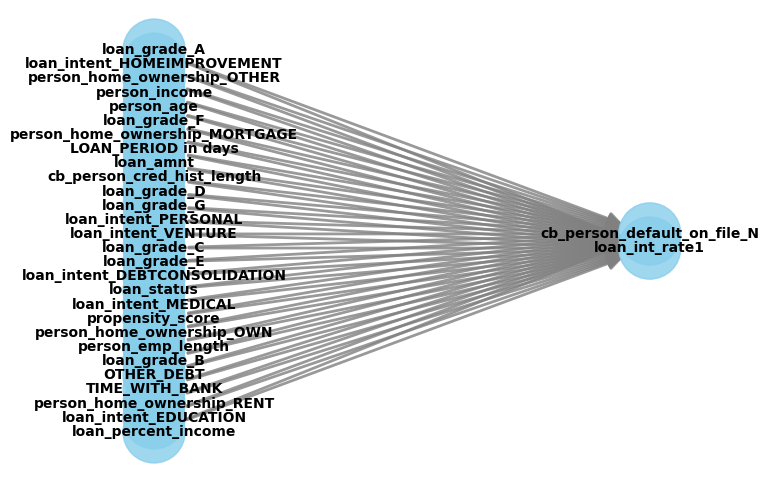

Fitting causal mechanism of node cb_person_default_on_file_N: 100%|██████████| 3/3 [00:00<00:00,  7.09it/s]


In [ ]:
causal_model = gcm.InvertibleStructuralCausalModel(nx.DiGraph([('loan_amnt', 'loan_int_rate1'), ('loan_int_rate1', 'cb_person_default_on_file_N')])) # X -> Y -> Z
gcm.auto.assign_causal_mechanisms(causal_model, df)
model.view_model()
gcm.fit(causal_model, df)

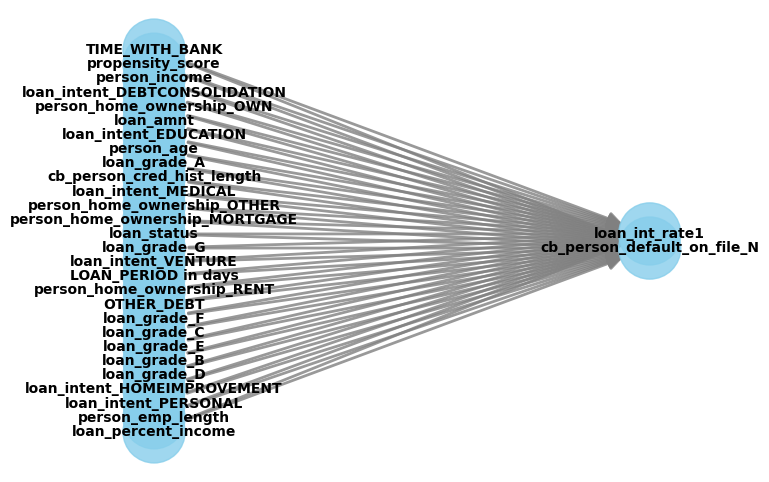

Fitting causal mechanism of node cb_person_default_on_file_N: 100%|██████████| 3/3 [00:00<00:00,  6.81it/s]


In [ ]:
causal_model1 = gcm.InvertibleStructuralCausalModel(
        nx.DiGraph([
            ('loan_amnt', 'loan_int_rate1'),
            ('loan_amnt', 'cb_person_default_on_file_N'),
            #('loan_amnt', 'propensity_score'),  # Add propensity_score as a node
            # ... any other causal relationships ...
        ])
    )

gcm.auto.assign_causal_mechanisms(causal_model1, df)
model.view_model()
gcm.fit(causal_model1, df)

##Intervention
Finally, let’s perform an intervention on X. Here, we explicitly perform the intervention
: X=1

In [ ]:
#Interventions

samples = gcm.interventional_samples(causal_model1,
                                     {'loan_amnt': lambda loan_amnt: 100},
                                     num_samples_to_draw=500)
samples.head(2)

,loan_amnt,loan_int_rate1,cb_person_default_on_file_N
0,100,2,1
1,100,2,1


In [ ]:
samples = gcm.interventional_samples(causal_model1,
                                     {'loan_amnt': lambda loan_amnt: loan_amnt + 0.5},
                                     num_samples_to_draw=500)
samples.head(2)

,loan_amnt,loan_int_rate1,cb_person_default_on_file_N
0,10.180344,1,1
1,10.074983,1,1


## **Counterfactual**

In [ ]:
observed_data = df[(df['loan_amnt'] >= 0.2) & (df['loan_int_rate1'] >= 0.5) & (df['cb_person_default_on_file_N'] == 0)]


In [ ]:
observed_data.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_status,loan_percent_income,cb_person_cred_hist_length,OTHER_DEBT,TIME_WITH_BANK,LOAN_PERIOD in days,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,loan_int_rate1
0,22,10.985293,123.0,10.463103,1,0.59,3,31681.02000,7,316.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
4,24,10.904119,8.0,10.463103,1,0.55,4,59393.20340,8,593.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
21,25,11.827736,9.0,10.457373,0,0.25,2,48655.75437,2,486.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
24,22,11.289782,3.0,10.432644,1,0.42,4,52589.23555,3,525.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
26,21,9.305651,3.0,8.428362,1,0.42,3,52753.41234,3,527.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1


In [ ]:
# Assuming you want to select rows where loan_amnt is 52, loan_int_rate1 is 5, and cb_person_default_on_file_N is 0
#observed_data = df[(df['loan_amnt'] == 52) & (df['loan_int_rate1'] == 5) & (df['cb_person_default_on_file_N'] == 0)]

# Now use observed_data in counterfactual_samples
gcm.counterfactual_samples(
    causal_model1,
    {'loan_amnt': lambda loan_amnt: 50},  # Assuming loan_amount is the treatment
    observed_data=observed_data
)


,loan_amnt,loan_int_rate1,cb_person_default_on_file_N
0,50,1,0.0
1,50,1,0.0
2,50,1,0.0
3,50,1,0.0
4,50,1,0.0
...,...,...,...
5704,50,1,0.0
5705,50,1,0.0
5706,50,2,0.0
5707,50,1,0.0


## **2. Bayesian Network for Causal Discovery using pgmpy:**

In [ ]:
# Define the structure of a Bayesian Network
model2 = BayesianNetwork([("loan_amnt", "loan_status_1"),
                          ("loan_amnt", "loan_int_rate1"),
                          ("person_income", "loan_status_1"),
                          ("person_income", "loan_int_rate1"),
                           ("loan_int_rate1", "loan_status_1"),
                          ("person_age", "loan_status_1"),
                          ("LOAN_PERIOD in days", "loan_status_1")])

# Estimate parameters based on data
model2.fit(df, estimator=MaximumLikelihoodEstimator)

# Query the model to perform inference
from pgmpy.inference import VariableElimination
inference = VariableElimination(model2)
result = inference.map_query(variables=["loan_status_1"], evidence={"loan_int_rate1": 1})
print("MAP Query Result for Default:", result)

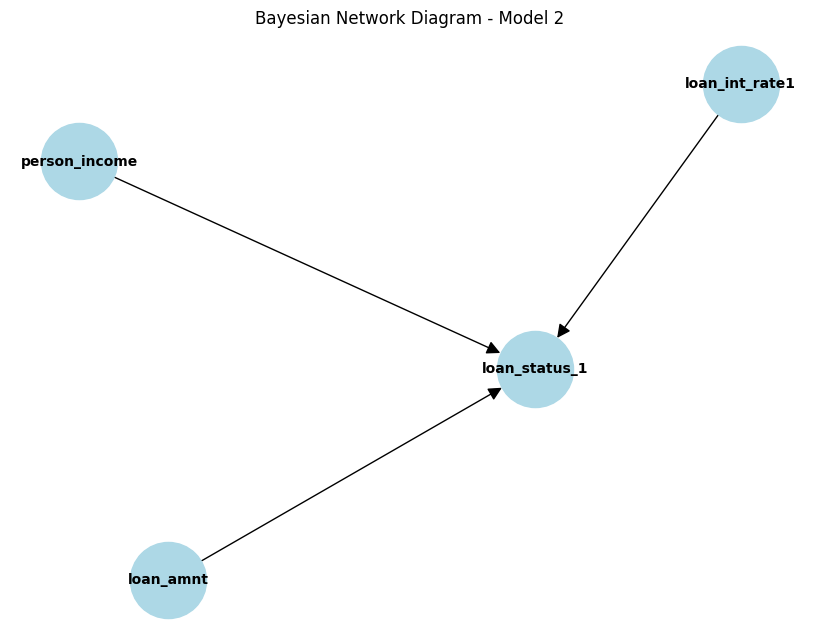

In [ ]:
nx_graph = nx.DiGraph()

# Add nodes and edges from the Bayesian Network
nx_graph.add_nodes_from(model2.nodes())
nx_graph.add_edges_from(model2.edges())

# Visualize the DAG using networkx and matplotlib
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(nx_graph)  # Layout for better positioning of nodes
nx.draw(nx_graph, pos, with_labels=True, node_size=3000, node_color="lightblue", font_size=10, font_weight="bold", arrowsize=20)
plt.title("Bayesian Network Diagram - Model 2")
plt.show()

In [ ]:
from pgmpy.estimators import MaximumLikelihoodEstimator

# Fit the model using Maximum Likelihood Estimation (MLE)
model2.fit(df, estimator=MaximumLikelihoodEstimator)

# Use BicScore to calculate the log-likelihood of the dataset
log_likelihood = BicScore(df).score(model2)

print(f"Log-Likelihood: {log_likelihood}")


Log-Likelihood: -33999417.69023406


In [ ]:
from pgmpy.estimators import BicScore

# BIC Score calculation
bic = BicScore(df).score(model2)

print(f"BIC Score: {bic}")


BIC Score: -33999417.69023406


common_causes=["person_age","person_income", "OTHER_DEBT", "person_emp_length",
                "loan_amnt","loan_percent_income","loan_status", "cb_person_cred_hist_length",
                "TIME_WITH_BANK", "LOAN_PERIOD in days","person_home_ownership_MORTGAGE",
                "person_home_ownership_OTHER","person_home_ownership_OWN","person_home_ownership_RENT",
                "loan_intent_DEBTCONSOLIDATION","loan_intent_EDUCATION","loan_intent_HOMEIMPROVEMENT",
                "loan_intent_MEDICAL","loan_intent_PERSONAL","loan_intent_VENTURE","loan_grade_A",
                "loan_grade_B","loan_grade_C","loan_grade_D","loan_grade_E","loan_grade_F","loan_grade_G","propensity_score"]


## **3. Causal Forest (Causal Tree Ensembles):**

In [ ]:
df.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,OTHER_DEBT,TIME_WITH_BANK,LOAN_PERIOD in days,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,loan_status_1
0,22,10.985293,123.0,10.463103,16.02,0.59,3,31681.020000,7,316.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,21,9.169518,5.0,6.907755,11.14,0.10,2,31437.140180,6,314.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,25,9.169518,1.0,8.612503,12.87,0.57,3,23979.127160,9,239.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
3,23,11.089805,4.0,10.463103,15.23,0.53,2,2602.283057,5,260.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
4,24,10.904119,8.0,10.463103,14.27,0.55,4,59393.203400,8,593.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
from econml.grf import CausalForest

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from econml.grf import CausalForest

In [ ]:
#Creating the X and y variables
X = df.drop('loan_status_1', axis = 1).values  #loan_status cb_person_default_on_file_N
Y = df['loan_status_1'].values
T = df['person_home_ownership_MORTGAGE'].values

# Spliting X and y into train and test version
# Train-Test Split
X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(X, T, Y, test_size=0.2, random_state=42)




In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
est = CausalForest(criterion='het', n_estimators=400, min_samples_leaf=5, max_depth=None,
                   min_var_fraction_leaf=None, min_var_leaf_on_val=True,
                   min_impurity_decrease = 0.0, max_samples=0.45, min_balancedness_tol=.45,
                   warm_start=False, inference=True, fit_intercept=True, subforest_size=4,
                   honest=True, verbose=0, n_jobs=-1, random_state=1235)

In [ ]:
est.fit(X, T, Y)

CausalForest(criterion='het', min_var_leaf_on_val=True, n_estimators=400,
             random_state=1235)

In [ ]:
# Predict treatment effects
treatment_effects = est.predict(X_test)

In [ ]:
 #Output some results
print("Estimated Treatment Effects for Test Set:")
print(treatment_effects[:10])

Estimated Treatment Effects for Test Set:
[[ 0.        ]
 [-0.12746448]
 [-0.55435457]
 [-0.55821284]
 [-0.52603929]
 [-0.54507862]
 [-0.60630949]
 [-0.11998091]
 [-0.12031918]
 [-0.1063937 ]]


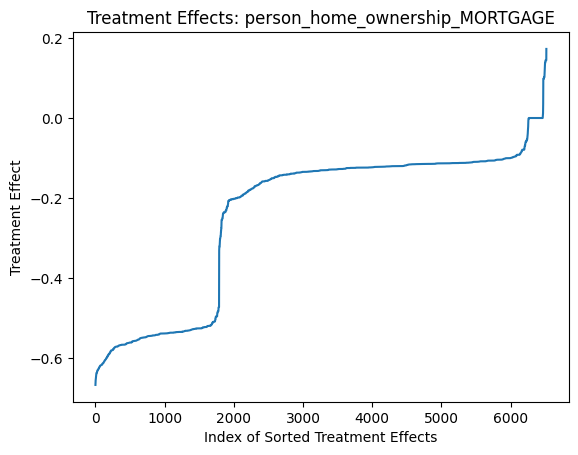

In [ ]:
# Flatten and sort the treatment_effects
treatment_effects_flat = treatment_effects.flatten()
treatment_effects_sorted = np.sort(treatment_effects_flat)
# Create the x-axis values (indices of the sorted effects)
x_values = np.arange(len(treatment_effects_sorted))
# Plot the line graph
plt.plot(x_values, treatment_effects_sorted)
plt.xlabel("Index of Sorted Treatment Effects")
plt.ylabel("Treatment Effect")
plt.title("Treatment Effects: person_home_ownership_MORTGAGE")
plt.show()

In [ ]:
index_of_interest = 1445  # The index you're interested in

# Retrieve the value from treatment_effects_sorted
y_value = treatment_effects_sorted[index_of_interest]

print(f"The value on the y-axis for Index {index_of_interest} is: {y_value}")

The value on the y-axis for Index 1445 is: -0.5277360247126772


## 1. Evaluate Performance:

### Compare Treatment Effects:

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score #To evaluate our model

In [ ]:
freq_table = pd.DataFrame(Y_test).value_counts().sort_index()

print(freq_table)

0  
0.0    5072
1.0    1445
Name: count, dtype: int64


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score



# Convert predicted treatment effects to binary labels (e.g., >0 means treatment is favorable)
binary_treatment_preds = (treatment_effects < -0.45277360247126772).astype(int)

# Compare predicted binary outcomes with true binary outcomes (Y_test)
conf_matrix = confusion_matrix(Y_test, binary_treatment_preds)
accuracy = accuracy_score(Y_test, binary_treatment_preds)

print("Confusion Matrix:")
print(conf_matrix)
print("\nAccuracy of Treatment Prediction:", accuracy)

print("\nAccuracy of Treatment Prediction:",classification_report(Y_test, binary_treatment_preds))

Confusion Matrix:
[[4044 1028]
 [ 686  759]]

Accuracy of Treatment Prediction: 0.7369955500997392

Accuracy of Treatment Prediction:               precision    recall  f1-score   support

         0.0       0.85      0.80      0.83      5072
         1.0       0.42      0.53      0.47      1445

    accuracy                           0.74      6517
   macro avg       0.64      0.66      0.65      6517
weighted avg       0.76      0.74      0.75      6517



In [ ]:
roc_auc = roc_auc_score(Y_test, binary_treatment_preds)

# Print AUC
print("AUC:", roc_auc)

AUC: 0.6612890637791581


Text(0.5, 1.0, 'ROC curve person_home_ownership_MORTGAGE')

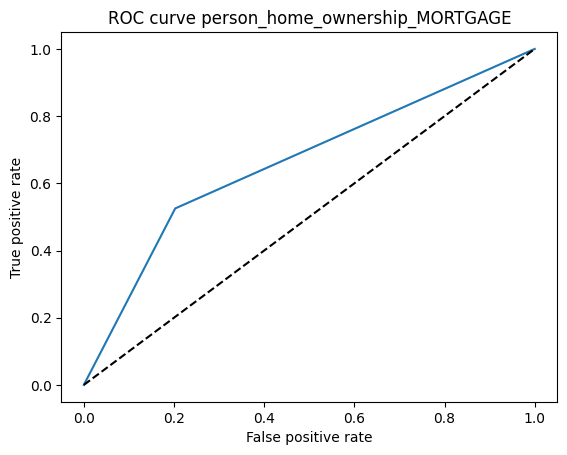

In [ ]:
roc_curve(Y_test, binary_treatment_preds)
fpr, tpr, thresholds = roc_curve(Y_test, binary_treatment_preds)
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve person_home_ownership_MORTGAGE')

##  Heterogeneous Treatment Effects Analysis
You can break down the predicted treatment effects by different subgroups or feature values. This is particularly useful to understand which subgroups (e.g., age, income level, or feature thresholds) benefit more from the treatment.

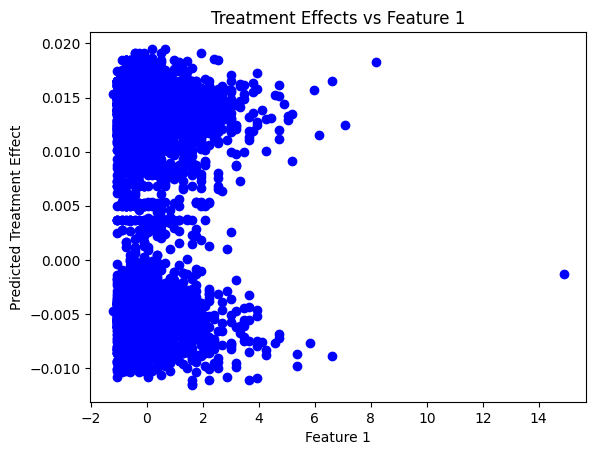

In [ ]:
# Example: Check how treatment effects vary with feature 1 (X[:, 0])
import matplotlib.pyplot as plt

plt.scatter(X_test[:, 0], treatment_effects, c='blue', label='Predicted Treatment Effect')
plt.xlabel("Feature 1")
plt.ylabel("Predicted Treatment Effect")
plt.title("Treatment Effects vs Feature 1")
plt.show()

## Average Treatment Effect (ATE) Estimation

Estimate the average treatment effect (ATE) by calculating the mean of the predicted treatment effects. This gives a general understanding of the overall effect of treatment in the population.

In [ ]:
# Average Treatment Effect (ATE)
ATE = np.mean(treatment_effects)
print(f"Average Treatment Effect (ATE): {ATE}")

Average Treatment Effect (ATE): -0.2400046705641175


## Conditional Average Treatment Effect (CATE)

Estimate the Conditional Average Treatment Effect (CATE) for different subsets or conditions. For example, how does the treatment effect vary for individuals with certain feature characteristics?

In [ ]:
# Conditional Average Treatment Effect for a subset where feature 1 > 0
CATE_feature1_positive = np.mean(treatment_effects[X_test[:, 0] > 0])
print(f"Conditional Average Treatment Effect (CATE) for Feature 1 > 0: {CATE_feature1_positive}")

Conditional Average Treatment Effect (CATE) for Feature 1 > 0: -0.23998056194665943


## Quantile Treatment Effects
Another interesting analysis is to calculate quantile treatment effects to see the range of treatment effects across the population.

In [ ]:
# Quantiles of treatment effects
treatment_effect_quantiles = np.percentile(treatment_effects, [10, 25, 50, 75, 90])
print("Quantile Treatment Effects:")
print(treatment_effect_quantiles)

Quantile Treatment Effects:
[-0.08079192 -0.05468066 -0.0035446   0.04096875  0.26831124]


## **Generalizability**

### Heterogeneity Analysis:

Assess how well the model generalizes across different subgroups in the data by evaluating its performance on various subpopulations (e.g., based on demographics or features).

Subgroup Analysis: Test the model's treatment effect predictions for different subgroups and check if there is consistent performance across these groups. If the model performs well on one group but poorly on others, this could indicate a lack of generalizability.

In [ ]:
# Assess performance on specific subgroups (e.g., X[:, 0] > 0)
from sklearn.metrics import mean_squared_error
subgroup_effects = est.predict(X_test[X_test[:, 0] > 0])
mse_subgroup = mean_squared_error(Y_test[X_test[:, 0] > 0], subgroup_effects)
print("Generalizability:-MSE for Subgroup with X[:, 0] > 0:", mse_subgroup)


Generalizability:-MSE for Subgroup with X[:, 0] > 0: 0.4476704315245848


## Perfoming an Intervantion

In [ ]:
import numpy as np

# Predict the treatment effect for the test set (CATE: Conditional Average Treatment Effect)
treatment_effects = est.predict(X_test)

# Perform an intervention: Assign all test samples to receive treatment (T=1)
T_intervention = np.ones_like(T_test)  # Set T=1 for all test samples
#T_test = 11

# Create T_intervention, filled with 11s instead of 1s
#T_intervention = np.full_like(T_test, 11)

# Now calculate the predicted outcome under intervention
# Predicted outcomes under intervention (T=1) = Base outcome + Treatment effect
Y_pred_intervention = (T_intervention * treatment_effects).flatten()

print("Predicted outcomes after the intervention (all treated):")
print(Y_pred_intervention[:10])



Predicted outcomes after the intervention (all treated):
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Assuming you have ground truth for Y_test after the intervention
# Y_test_actual contains the actual observed outcomes (binary labels: 0 or 1)

# Let's say Y_test_actual is your true outcome (replace this with your actual data)
# For now, assuming Y_test is the ground truth (if you have it for the intervention)
Y_test_actual = Y_test  # Replace with true outcomes
Y_test_actual = np.random.choice(Y_test, size=6516, replace=False)
# Convert predicted probabilities/values to binary predictions (0 or 1)
# Assuming Y_pred_intervention are the probabilities, convert to binary labels
Y_pred_binary = (Y_pred_intervention < -0.45277360247126772).astype(int)  # Threshold of 0.5 for binary classification

import numpy as np

# Assume Y_pred_binary has binary values (0s and 1s)
# Step 1: Separate 0s and 1s (or other unique values)
class_0 = Y_pred_binary[Y_pred_binary == 0]
class_1 = Y_pred_binary[Y_pred_binary == 1]

# Step 2: Find the minimum class size to avoid oversampling
min_class_size = min(len(class_0), len(class_1), len(Y_test_actual) // 2)

# Step 3: Randomly sample from each class
sampled_class_0 = np.random.choice(class_0, size=min_class_size, replace=False)
sampled_class_1 = np.random.choice(class_1, size=min_class_size, replace=False)

# Step 4: Combine the samples and shuffle the result
Y_pred_sampled = np.concatenate([sampled_class_0, sampled_class_1])
np.random.shuffle(Y_pred_sampled)  # Shuffle to avoid ordered predictions

# Ensure the final sampled array has the same length as Y_test_actual
Y_pred_sampled = Y_pred_sampled[:len(Y_test_actual)]  # Trim in case of overflow

# Now Y_pred_sampled has equal numbers of 0s and 1s, and can be compared with Y_test_actual


# Now you can compare Y_pred_sampled with Y_test_actual


# 1. Calculate Accuracy
accuracy = accuracy_score(Y_test_actual, Y_pred_sampled)
print(f"Accuracy after intervention: {accuracy:.4f}")

# 2. Confusion Matrix
conf_matrix = confusion_matrix(Y_test_actual, Y_pred_sampled)
print("Confusion Matrix:")
print(conf_matrix)

# 3. Classification Report (Precision, Recall, F1-Score)
class_report = classification_report(Y_test_actual, Y_pred_sampled)
print("Classification Report:")
print(class_report)


Accuracy after intervention: 0.4949
Confusion Matrix:
[[2519 2552]
 [ 739  706]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.50      0.60      5071
         1.0       0.22      0.49      0.30      1445

    accuracy                           0.49      6516
   macro avg       0.49      0.49      0.45      6516
weighted avg       0.65      0.49      0.54      6516



Text(0.5, 1.0, 'ROC curve Time With Bank')

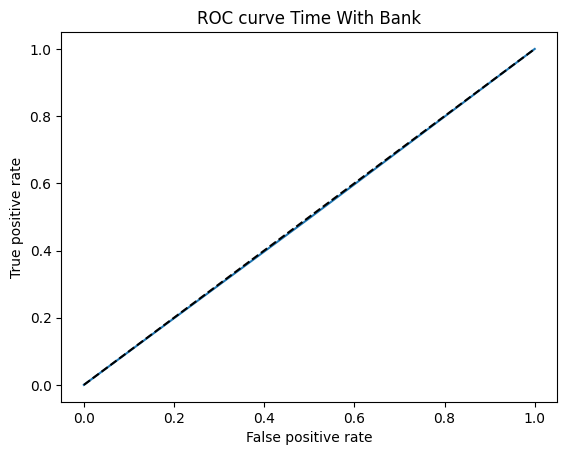

In [ ]:
roc_curve(Y_test_actual, Y_pred_sampled)
fpr, tpr, thresholds = roc_curve(Y_test_actual, Y_pred_sampled)
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve Time With Bank')

## Counterfactual

In [ ]:
# Simulate counterfactual outcomes (opposite treatment for each individual)
T_counterfactual = 1 - T_test  # Flip the treatment
Y_pred_counterfactual = est.predict(X_test)

# If ground truth for counterfactuals is available (rare in practice), compare with actual data
mse_counterfactual = mean_squared_error(T_counterfactual, Y_pred_counterfactual)

print("MSE for Counterfactual Outcomes:", mse_counterfactual)


MSE for Counterfactual Outcomes: 0.97602727916795


## **4. Invariant Causal Prediction (ICP):**

In [ ]:
pip install causalicp


In [ ]:
pip install cdt


  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 921.1/921.1 kB 12.0 MB/s eta 0:00:00
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=b906c959887bf8771ad0162220aa23167d8cecbb45950a8a49463de236b71611
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
  Created wheel for skrebate: filename=skrebate-0.62-py3-none-any.whl size=29256 sha256=4d51dffb36a02772ea3bdfd9f8f8c63847b3ac77ad9ea09c464e897a500f543c
  Stored in directory: /root/.cache/pip/wheels/dd/67/40/683074a684607162bd0e34dcf7ccdfcab5861c3b2a83286f3a
Successfully built GPUtil skrebate


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from invariant_causal.ICP import InvariantCausalPrediction

ModuleNotFoundError: No module named 'invariant_causal'

In [ ]:
# You can use the econml library for Double Machine Learning (DML), which includes invariant causal prediction.
# Let's apply it for credit scoring causal effect estimation.

estimator = CausalForestDML(model_y=RandomForestRegressor(), model_t=RandomForestRegressor())
estimator.fit(Y, T, X=X)

# Estimate the causal effect of treatment on the outcome
treatment_effect = estimator.effect(X)
print("Estimated Treatment Effect using Causal Forest DML:", treatment_effect)

## **5. Counterfactual Reasoning:**

In [ ]:
# Using DoWhy's counterfactual reasoning
counterfactuals = model.estimate_counterfactuals(data, treatment="interest_rate", outcome="default")
print("Counterfactuals:", counterfactuals)

## **6. Propensity Score Matching (PSM):**

In [ ]:
from causalml.propensity import ElasticNetPropensityModel
ps_model = ElasticNetPropensityModel()
ps_model.fit(X, treatment)

# Estimate propensity scores
ps_scores = ps_model.predict_proba(X)
print("Propensity Scores:", ps_scores)

## **7. Model Deployment (e.g., Flask):**

In [ ]:
from flask import Flask, request, jsonify
import joblib

app = Flask(__name__)

# Assume causal_model is your trained causal ML model
joblib.dump(causal_forest, "causal_model.pkl")
causal_model = joblib.load("causal_model.pkl")

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json(force=True)
    prediction = causal_model.estimate_ate(X_test=[data['credit_score'], data['income'], data['loan_amount']])
    return jsonify({"treatment_effect": prediction})

if __name__ == "__main__":
    app.run(debug=True)

https://github.com/dzrich/PhD_Research_in_CausalML/tree/main/Data